# Download Dataset

---



---



In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy,SparseTopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive, files
from tensorflow.keras.utils import plot_model


In [ ]:
! pip install -q kaggle
files.upload()

In [4]:
# Create a directory for the Kaggle API key
!mkdir ~/.kaggle

# Move the uploaded kaggle.json to the directory
!cp kaggle.json ~/.kaggle/

# Set the correct permissions on the file
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d ananthu017/emotion-detection-fer

 80% 52.0M/65.2M [00:00<00:00, 190MB/s]
100% 65.2M/65.2M [00:00<00:00, 186MB/s]


In [6]:
!unzip emotion-detection-fer.zip -d emotion-detection

Streaming output truncated to the last 5000 lines.
  inflating: emotion-detection/train/sad/im37.png  
  inflating: emotion-detection/train/sad/im370.png  
  inflating: emotion-detection/train/sad/im3700.png  
  inflating: emotion-detection/train/sad/im3701.png  
  inflating: emotion-detection/train/sad/im3702.png  
  inflating: emotion-detection/train/sad/im3703.png  
  inflating: emotion-detection/train/sad/im3704.png  
  inflating: emotion-detection/train/sad/im3705.png  
  inflating: emotion-detection/train/sad/im3706.png  
  inflating: emotion-detection/train/sad/im3707.png  
  inflating: emotion-detection/train/sad/im3708.png  
  inflating: emotion-detection/train/sad/im3709.png  
  inflating: emotion-detection/train/sad/im371.png  
  inflating: emotion-detection/train/sad/im3710.png  
  inflating: emotion-detection/train/sad/im3711.png  
  inflating: emotion-detection/train/sad/im3712.png  
  inflating: emotion-detection/train/sad/im3713.png  
  inflating: emotion-detection/trai

# Dataset Preprocessing

---



---



In [2]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.2,
    "REGULARIZATION_RATE": 0.001,
    "N_FILTERS": 64,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 7,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "disgusted","fearful","happy","neutral", "sad","surprised"],
}

In [3]:
train_directory = '/content/emotion-detection/train'
test_directory = '/content/emotion-detection/test'

angry has 3995 files
disgusted has 436 files
fearful has 4097 files
happy has 7215 files
neutral has 4965 files
sad has 4830 files
surprised has 3171 files


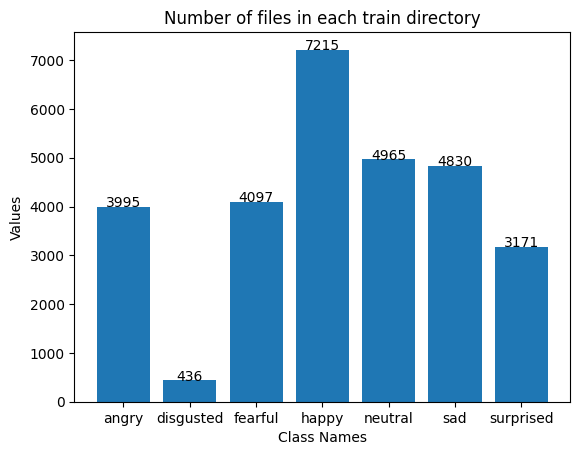

In [4]:
files_counts = []
for class_name in CONFIGURATION['CLASS_NAMES']:
  files = len(os.listdir(train_directory+'/'+class_name))
  files_counts.append(files)
  print(f'{class_name} has {files} files')

x_axis = CONFIGURATION['CLASS_NAMES']
y_axis = files_counts

plt.bar(x_axis, y_axis)
plt.title('Number of files in each train directory')
plt.xlabel('Class Names')
plt.ylabel('Values')
for i,x_label in enumerate(x_axis):
        plt.text(i,y_axis[i],y_axis[i],ha = 'center')
plt.show()

As we can see above each folder has different number of files which will affect the model's performance because now the model can learn someone is happy more than if someone is disgusted
To solve this, there are a few ways, 3 of them are:


*   Undersampling: this method makes all classes have same amount of images but makes them all equal to the class containing the minimum number of images(minority class)
*   Oversampling: this method makes all classes have same amount of images but makes them all equal to the folder containing the maximum number of images (majority class) and that is done by adding some of the images of one class again into the same class till it reaches the required amount
*   Class weighting: this method gives a weight to each class so that for example when the model learns a disgusted image and classifies it wrong, the model's penalty is increased in comparison to misclassifying a happy image because the loss increases when misclassifying a disgusted image due to having larger weights

I will be using the class weighting method in training some of the models below.





In [5]:
total_files = sum(files_counts)
class_weights = {}
for i, class_name in enumerate(CONFIGURATION['CLASS_NAMES']):
  class_weights[i] = total_files/files_counts[i]
print(total_files)
print(class_weights)

28709
{0: 7.186232790988736, 1: 65.84633027522936, 2: 7.007322431047108, 3: 3.979071379071379, 4: 5.782275931520645, 5: 5.943892339544513, 6: 9.053610848312836}


In [6]:
train_ds,val_ds=tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='int',
    class_names=CONFIGURATION['CLASS_NAMES'],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=99,
    validation_split=0.15,
    subset='both'
)

Found 28709 files belonging to 7 classes.
Using 24403 files for training.
Using 4306 files for validation.


In [7]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
train_ds.take(1).unbatch()
for im,label in train_ds.take(1).unbatch():
  print(label)
  print(im)
  print("-----------------------------------------------------------")
  # to get one channel
  print(im[:,:,0])
  print("-----------------------------------------------------------")
  max = tf.math.reduce_max(im)
  print(max)
  min = tf.math.reduce_min(im)
  print(min)
  break

tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(
[[[ 10.  10.  10.]
  [ 10.  10.  10.]
  [ 10.  10.  10.]
  ...
  [181. 181. 181.]
  [181. 181. 181.]
  [181. 181. 181.]]

 [[ 10.  10.  10.]
  [ 10.  10.  10.]
  [ 10.  10.  10.]
  ...
  [181. 181. 181.]
  [181. 181. 181.]
  [181. 181. 181.]]

 [[ 10.  10.  10.]
  [ 10.  10.  10.]
  [ 10.  10.  10.]
  ...
  [181. 181. 181.]
  [181. 181. 181.]
  [181. 181. 181.]]

 ...

 [[205. 205. 205.]
  [205. 205. 205.]
  [205. 205. 205.]
  ...
  [243. 243. 243.]
  [243. 243. 243.]
  [243. 243. 243.]]

 [[205. 205. 205.]
  [205. 205. 205.]
  [205. 205. 205.]
  ...
  [243. 243. 243.]
  [243. 243. 243.]
  [243. 243. 243.]]

 [[205. 205. 205.]
  [205. 205. 205.]
  [205. 205. 205.]
  ...
  [243. 243. 243.]
  [243. 243. 243.]
  [243. 243. 243.]]], shape=(256, 256, 3), dtype=float32)
-----------------------------------------------------------
tf.Tensor(
[[ 10.  10.  10. ... 181. 181. 181.]
 [ 10.  10.  10. ... 181. 181. 181.]
 [ 10.  10.  10. ... 181. 181. 18

In [9]:
len(val_ds)

135

In [10]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_directory,
    labels='inferred',
    label_mode='int',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=False,
    seed=99,
)

Found 7178 files belonging to 7 classes.


# Data Visualization

---



---



In [11]:
def visualize_data(ds,k):
  fig, ax = plt.subplots(1,k,figsize=(12, 5 * k), gridspec_kw={'hspace': 1})
  batch = ds.take(1)
  for i,(im,label) in enumerate(batch.unbatch()):
    if(i==k):
      break
    ax[i].imshow(im/255.)
    label = CONFIGURATION["CLASS_NAMES"][label]
    ax[i].set_title(label)
    ax[i].axis('off')

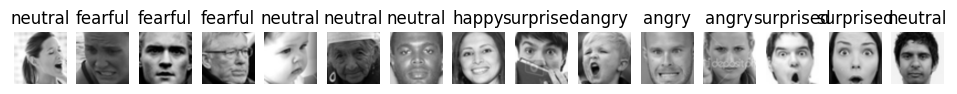

In [12]:
visualize_data(train_ds,15)

# Data Augmentation

---



In [13]:
def resize_rescale(image,label):
  image = tf.image.resize(image,size=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']))
  image/=255
  return image,label

In [14]:
train_ds_normal = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Using TF API

---



In [15]:
0.025*360

9.0

In [16]:
augment_layers = tf.keras.Sequential([
  RandomRotation(factor = (-0.025, 0.025)),# rotates images from -9 degrees to +9 degrees to avoid rotations like 90 degrees and so on so that data would not be distorted
  RandomFlip(mode='horizontal',),
  RandomContrast(factor=0.1),
])

def augment_layer(image, label):
  return augment_layers(image, training = True), label

In [17]:
training_dataset_normal_aug = (
    train_ds
    .map(resize_rescale,num_parallel_calls = tf.data.AUTOTUNE)
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

## Cutmix Data Augmentation

---


lets mix some of the images from train dataset together to see how the model would react to it

https://paperswithcode.com/method/cutmix



(-0.5, 255.5, 255.5, -0.5)

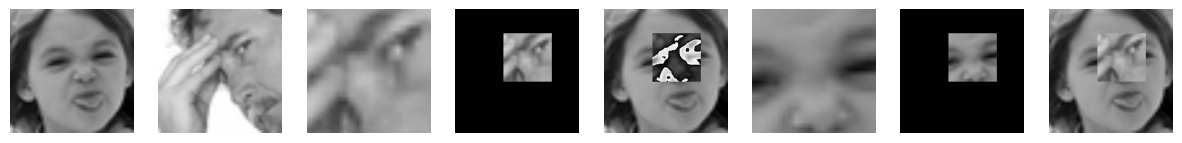

In [18]:
plt.figure(figsize=(15,15))
plt.subplot(1,8,1)
image_1 = cv2.imread('/content/emotion-detection/train/angry/im100.png')
image_1 = cv2.resize(image_1,(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']))
plt.imshow(image_1)
plt.axis('off')

plt.subplot(1,8,2)
image_2 = cv2.imread('/content/emotion-detection/train/angry/im1000.png')
image_2 = cv2.resize(image_2,(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']))
plt.imshow(image_2)
plt.axis('off')

plt.subplot(1,8,3)
image_3 = cv2.imread('/content/emotion-detection/train/angry/im1000.png')
image_3 = cv2.resize(image_3,(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']))
image_3 = tf.image.crop_to_bounding_box(image_3, 50, 100, 100, 100)
plt.imshow(image_3)
plt.axis('off')

plt.subplot(1,8,4)
image_4 = tf.image.pad_to_bounding_box(image_3, 50, 100, CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'])
plt.imshow(image_4)
plt.axis('off')

plt.subplot(1,8,5)
plt.imshow(image_1+image_4)
plt.axis('off')

plt.subplot(1,8,6)
image_5 = tf.image.crop_to_bounding_box(image_1, 50, 100, 100, 100)
plt.imshow(image_5)
plt.axis('off')

plt.subplot(1,8,7)
image_6 = tf.image.pad_to_bounding_box(image_5, 50, 100, CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'])
plt.imshow(image_6)
plt.axis('off')

plt.subplot(1,8,8)
plt.imshow(image_1-image_6+image_4)
plt.axis('off')



In [19]:
tfp.distributions.Uniform(
    low=0.0,
    high=CONFIGURATION['IM_SIZE'],
    name='Uniform'
).sample(1)[0].numpy()

42.687256

In [20]:
def box(lamda):
  r_x = tf.cast(
      tfp.distributions.Uniform(
        low=0.0,
        high=CONFIGURATION['IM_SIZE'],
        name='Uniform'
      ).sample(1)[0], dtype=tf.int32)

  r_y = tf.cast(
      tfp.distributions.Uniform(
        low=0.0,
        high=CONFIGURATION['IM_SIZE'],
        name='Uniform'
      ).sample(1)[0], dtype=tf.int32)

  r_w = tf.cast(CONFIGURATION['IM_SIZE']*tf.sqrt(1-lamda),dtype=tf.int32)
  r_h = tf.cast(CONFIGURATION['IM_SIZE']*tf.sqrt(1-lamda),dtype=tf.int32)

  r_x_top_left = tf.clip_by_value(tf.cast(r_x-r_w//2,dtype=tf.int32),0,CONFIGURATION['IM_SIZE'])
  r_y_top_left = tf.clip_by_value(tf.cast(r_y-r_h//2,dtype=tf.int32),0,CONFIGURATION['IM_SIZE'])

  r_x_bottom_right = tf.clip_by_value(r_x_top_left+r_w//2,0,CONFIGURATION['IM_SIZE'])
  r_y_bottom_right = tf.clip_by_value(r_y_top_left+r_h//2,0,CONFIGURATION['IM_SIZE'])

  r_w = r_x_bottom_right-r_x_top_left
  if(r_w == 0):
    r_w  = 1

  r_h = r_y_bottom_right-r_y_top_left
  if(r_h == 0):
    r_h  = 1

  return r_y_top_left, r_x_top_left, r_h, r_w

In [21]:
def cutmix(train_ds_1, train_ds_2):
  (image_1,label_1),(image_2,label_2) = train_ds_1, train_ds_2

  lamda = tfp.distributions.Beta(2,2).sample(1)[0]
  # print(lamda)
  r_y, r_x, r_h, r_w = box(lamda)

  crop_1 = tf.image.crop_to_bounding_box(image_1,r_y,r_x,r_h,r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1,r_y,r_x,CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'])

  crop_2 = tf.image.crop_to_bounding_box(image_2,r_y,r_x,r_h,r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2,r_y,r_x,CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'])

  result_image = image_1-pad_1+pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return result_image, label

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


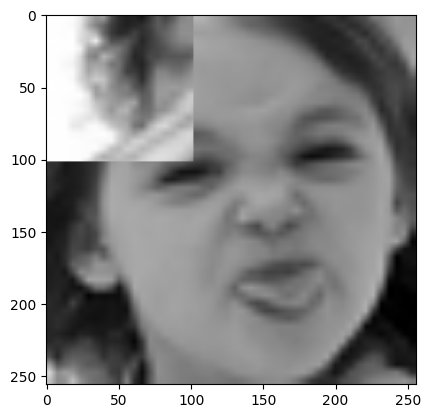

In [22]:
res,_ = cutmix((image_1,0),(image_2,0))
plt.imshow(res)

In [23]:
train_dataset_1 = (
                    train_ds
                    .map(augment_layer,num_parallel_calls = tf.data.AUTOTUNE)
                    .map(resize_rescale,num_parallel_calls = tf.data.AUTOTUNE)
                    # .shuffle(buffer_size = 128)
                  )
train_dataset_2 = (
                    train_ds
                    .map(augment_layer,num_parallel_calls = tf.data.AUTOTUNE)
                    .map(resize_rescale,num_parallel_calls = tf.data.AUTOTUNE)
                    # .shuffle(buffer_size = 128)
                  )

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [24]:
mixed_dataset

<_ZipDataset element_spec=((TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)), (TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)))>

In [25]:
training_dataset_cutmix = (
    mixed_dataset
    .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [26]:
training_dataset_cutmix

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

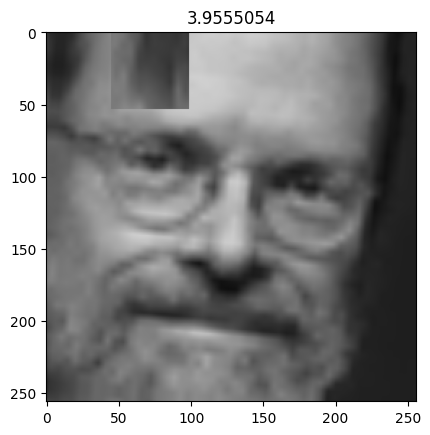

In [27]:
for im,label in training_dataset_cutmix.take(1).unbatch():
  plt.title(label.numpy())
  plt.imshow(im)
  break

## Mixup Data Augmentation

---

https://paperswithcode.com/method/mixup

(-0.5, 255.5, 255.5, -0.5)

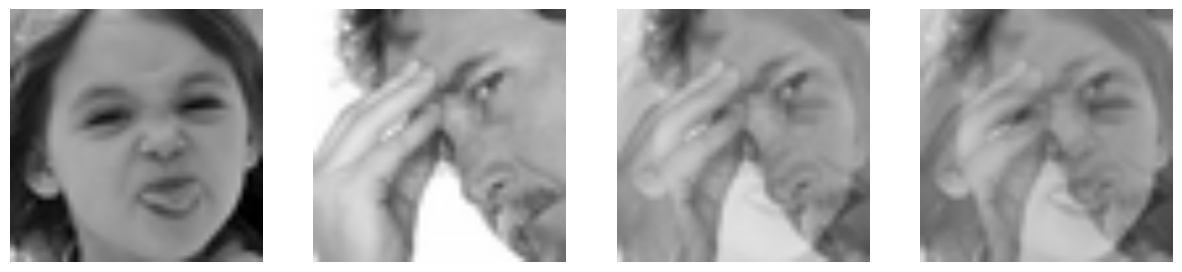

In [28]:
plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
image_1 = cv2.imread('/content/emotion-detection/train/angry/im100.png')
image_1 = cv2.resize(image_1,(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']))
plt.imshow(image_1)
plt.axis('off')

plt.subplot(1,4,2)
image_2 = cv2.imread('/content/emotion-detection/train/angry/im1000.png')
image_2 = cv2.resize(image_2,(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']))
plt.imshow(image_2)
plt.axis('off')

plt.subplot(1,4,3)
result_image = 0.3*image_1+(1-0.3)*image_2
plt.imshow(result_image/255)
plt.axis('off')

plt.subplot(1,4,4)
result_image_2 = 0.5*image_1+(1-0.5)*image_2
plt.imshow(result_image_2/255)
plt.axis('off')

In [29]:
def mixup(train_ds_1,train_ds_2):
  (image_1,label_1),(image_2,label_2) = train_ds_1, train_ds_2

  lamda = tfp.distributions.Beta(2,2).sample(1)[0]
  result_image = lamda*image_1+(1-lamda)*image_2
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return result_image, label

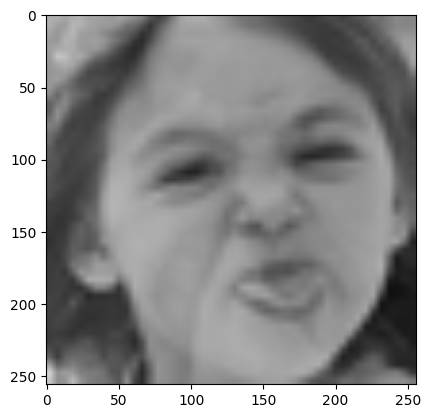

In [30]:
res,_ = mixup((image_1,0),(image_2,0))
plt.imshow(res/255)

In [31]:
train_dataset_mixup_1 = (
                    train_ds
                    # .shuffle(buffer_size = 128)
                    .map(resize_rescale,num_parallel_calls = tf.data.AUTOTUNE)
                    )

train_dataset_mixup_2 = (
                    train_ds
                    # .shuffle(buffer_size = 128)  it causes errors in training due to incompatible batch sizes
                    .map(resize_rescale,num_parallel_calls = tf.data.AUTOTUNE)
                    )


mixed_dataset_mixup = tf.data.Dataset.zip((train_dataset_mixup_1, train_dataset_mixup_2))

In [32]:
training_dataset_mixup = (
    mixed_dataset_mixup
    .map(mixup, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

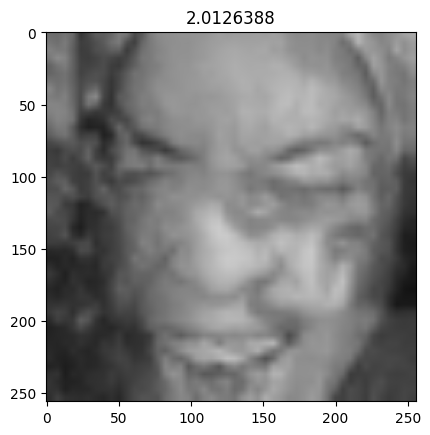

In [33]:
for im,label in training_dataset_mixup.take(1).unbatch():
  plt.title(label.numpy())
  plt.imshow(im)
  break

# Modelling

---





In [34]:
def plot_loss_accuracy_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['sparse_categorical_accuracy']
  val_accuracy = history.history['val_sparse_categorical_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')

  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')

  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

In [35]:
metrics=[SparseCategoricalAccuracy(),SparseTopKCategoricalAccuracy(k=3)]

In [36]:
reduce_lr_on_plateau=ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)
callbacks=[reduce_lr_on_plateau]

## Try out a simple CNN model

In [37]:
inputs = Input(shape=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"],3))
x = Conv2D(64,kernel_size=(3,3),strides=1,padding='valid',activation='relu')(inputs)
x = Conv2D(128,kernel_size=(3,3),strides=1,padding='valid',activation='relu')(x)
x = MaxPool2D(2)(x)
x = Flatten()(x)
x = Dense(64,activation='relu')(x)
outputs = Dense(7,activation='softmax')(x)

model_0 = Model(inputs,outputs,name='base_model')

In [ ]:
model_0.compile(loss=SparseCategoricalCrossentropy(),
                optimizer=Adam(),
                metrics=metrics)

###Lets try it on the normal dataset

In [ ]:
model_0_history=model_0.fit(train_ds_normal,
            epochs=10,
            validation_data=val_ds)

Epoch 1/10
763/763 [==============================] - 42s 46ms/step - loss: 54.0678 - sparse_categorical_accuracy: 0.2495 - sparse_top_k_categorical_accuracy: 0.6032 - val_loss: 1.8042 - val_sparse_categorical_accuracy: 0.2641 - val_sparse_top_k_categorical_accuracy: 0.6061
Epoch 2/10
763/763 [==============================] - 34s 44ms/step - loss: 1.7239 - sparse_categorical_accuracy: 0.3007 - sparse_top_k_categorical_accuracy: 0.6565 - val_loss: 1.9167 - val_sparse_categorical_accuracy: 0.2654 - val_sparse_top_k_categorical_accuracy: 0.6384
Epoch 3/10
763/763 [==============================] - 34s 44ms/step - loss: 1.5514 - sparse_categorical_accuracy: 0.3783 - sparse_top_k_categorical_accuracy: 0.7122 - val_loss: 2.3277 - val_sparse_categorical_accuracy: 0.2654 - val_sparse_top_k_categorical_accuracy: 0.6328
Epoch 4/10
763/763 [==============================] - 34s 44ms/step - loss: 1.3921 - sparse_categorical_accuracy: 0.4515 - sparse_top_k_categorical_accuracy: 0.7518 - val_loss: 

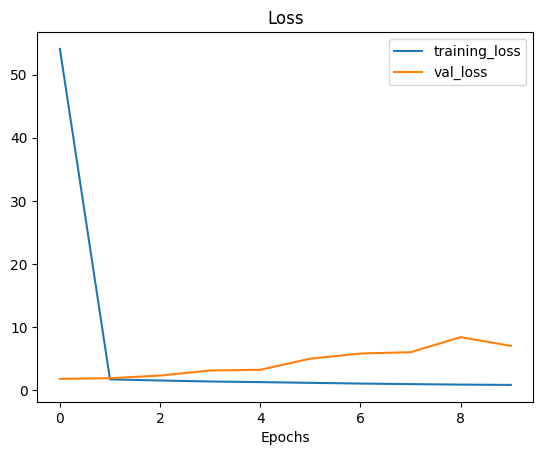

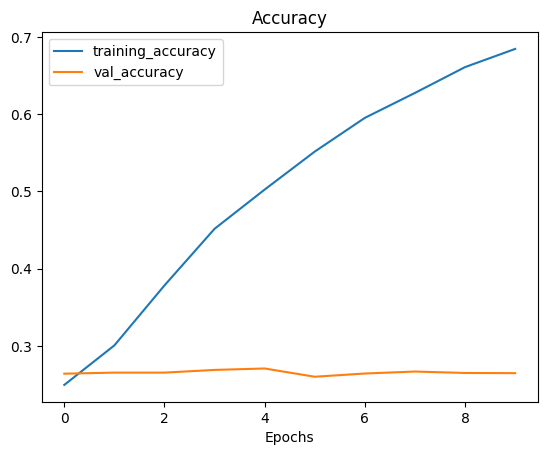

In [ ]:
plot_loss_accuracy_curves(model_0_history)

In [ ]:
model_0.evaluate(test_ds)

225/225 [==============================] - 4s 19ms/step - loss: 7.1085 - sparse_categorical_accuracy: 0.2673 - sparse_top_k_categorical_accuracy: 0.6172


[7.10847282409668, 0.2673446536064148, 0.6171635389328003]

In [42]:
path_to_drive = '/content/drive/MyDrive/Colab Notebooks/human emotions detection/'
path_to_models = path_to_drive + 'models/'

In [ ]:
model_0_path = path_to_models+'model_0.h5'
model_0.save(model_0_path)

### Now lets try it using the class weights to reduce class imbalance

In [ ]:
model_4 = tf.keras.models.clone_model(model_0)
model_4.compile(loss=SparseCategoricalCrossentropy(),
                optimizer=Adam(),
                metrics=metrics)
model_4_history=model_4.fit(train_ds_normal,
            epochs=10,
            validation_data=val_ds,
            class_weight=class_weights)

Epoch 1/10
763/763 [==============================] - 36s 45ms/step - loss: 639.0887 - sparse_categorical_accuracy: 0.1636 - sparse_top_k_categorical_accuracy: 0.4866 - val_loss: 1.9395 - val_sparse_categorical_accuracy: 0.1491 - val_sparse_top_k_categorical_accuracy: 0.5402
Epoch 2/10
763/763 [==============================] - 34s 44ms/step - loss: 16.4318 - sparse_categorical_accuracy: 0.1563 - sparse_top_k_categorical_accuracy: 0.4565 - val_loss: 1.9636 - val_sparse_categorical_accuracy: 0.2559 - val_sparse_top_k_categorical_accuracy: 0.5197
Epoch 3/10
763/763 [==============================] - 34s 44ms/step - loss: 12.7402 - sparse_categorical_accuracy: 0.1862 - sparse_top_k_categorical_accuracy: 0.5187 - val_loss: 2.0861 - val_sparse_categorical_accuracy: 0.2485 - val_sparse_top_k_categorical_accuracy: 0.4891
Epoch 4/10
763/763 [==============================] - 34s 44ms/step - loss: 11.7472 - sparse_categorical_accuracy: 0.2386 - sparse_top_k_categorical_accuracy: 0.5564 - val_lo

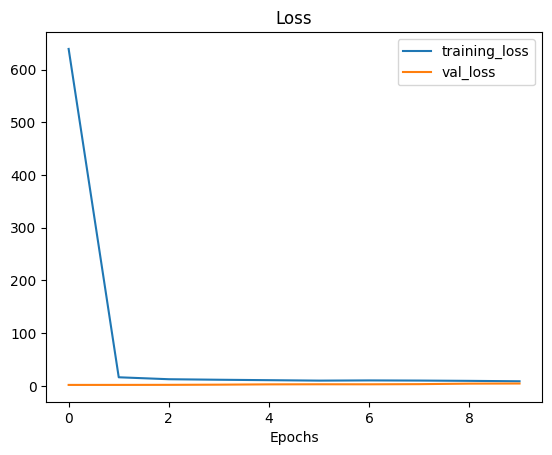

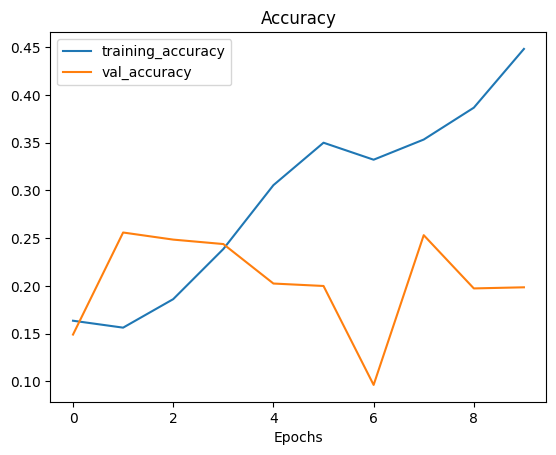

In [ ]:
plot_loss_accuracy_curves(model_4_history)

In [ ]:
model_4.evaluate(test_ds)

225/225 [==============================] - 4s 18ms/step - loss: 4.3804 - sparse_categorical_accuracy: 0.2052 - sparse_top_k_categorical_accuracy: 0.5007


[4.3804192543029785, 0.2052103579044342, 0.50069659948349]

In [ ]:
model_4_path = path_to_models+'model_4.h5'
model_4.save(model_4_path)

###Now lets try it on the normally augmented dataset using TF API

In [ ]:
model_1 = tf.keras.models.clone_model(model_0)
model_1.compile(loss=SparseCategoricalCrossentropy(),
                optimizer=Adam(),
                metrics=metrics)
model_1_history=model_1.fit(training_dataset_normal_aug,
            epochs=10,
            validation_data=val_ds)

Epoch 1/10
763/763 [==============================] - 38s 47ms/step - loss: 2.1740 - sparse_categorical_accuracy: 0.2512 - sparse_top_k_categorical_accuracy: 0.5960 - val_loss: 10.8277 - val_sparse_categorical_accuracy: 0.2645 - val_sparse_top_k_categorical_accuracy: 0.6287
Epoch 2/10
763/763 [==============================] - 36s 47ms/step - loss: 1.6907 - sparse_categorical_accuracy: 0.3259 - sparse_top_k_categorical_accuracy: 0.6832 - val_loss: 30.0445 - val_sparse_categorical_accuracy: 0.2766 - val_sparse_top_k_categorical_accuracy: 0.6544
Epoch 3/10
763/763 [==============================] - 36s 47ms/step - loss: 1.6541 - sparse_categorical_accuracy: 0.3475 - sparse_top_k_categorical_accuracy: 0.7045 - val_loss: 58.0587 - val_sparse_categorical_accuracy: 0.2722 - val_sparse_top_k_categorical_accuracy: 0.7016
Epoch 4/10
763/763 [==============================] - 36s 47ms/step - loss: 1.5979 - sparse_categorical_accuracy: 0.3684 - sparse_top_k_categorical_accuracy: 0.7256 - val_loss

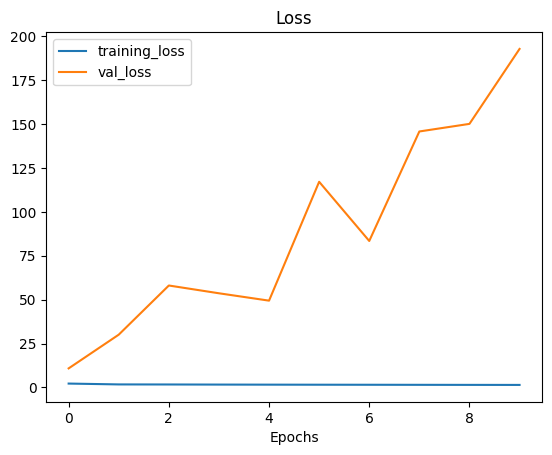

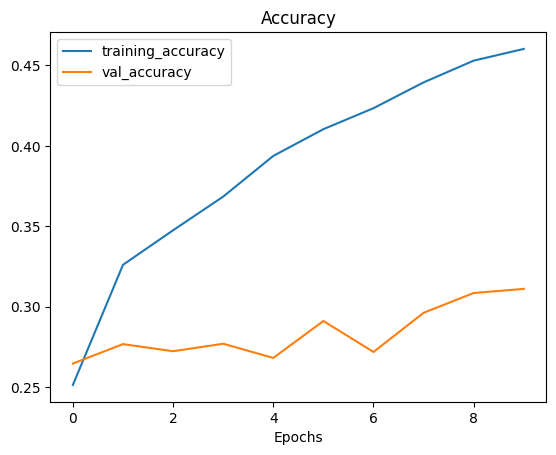

In [ ]:
plot_loss_accuracy_curves(model_1_history)

In [ ]:
model_1.evaluate(test_ds)

225/225 [==============================] - 4s 18ms/step - loss: 191.3974 - sparse_categorical_accuracy: 0.3132 - sparse_top_k_categorical_accuracy: 0.9217


[191.39739990234375, 0.3131791651248932, 0.9217051863670349]

In [ ]:
model_1_path = path_to_models+'model_1.h5'
model_1.save(model_1_path)

### Now lets try it on the augmented dataset using cutmix

In [64]:
model_2 = tf.keras.models.clone_model(model_0)
model_2.compile(loss=SparseCategoricalCrossentropy(),
                optimizer=Adam(),
                metrics=metrics)
model_2_history=model_2.fit(
    training_dataset_cutmix,
            epochs=5,
            validation_data=val_ds)

Epoch 1/5
763/763 [==============================] - 94s 118ms/step - loss: 1.9607 - sparse_categorical_accuracy: 0.0550 - sparse_top_k_categorical_accuracy: 0.6634 - val_loss: 1.9768 - val_sparse_categorical_accuracy: 0.2580 - val_sparse_top_k_categorical_accuracy: 0.5720
Epoch 2/5
763/763 [==============================] - 91s 118ms/step - loss: 1.7007 - sparse_categorical_accuracy: 0.0615 - sparse_top_k_categorical_accuracy: 0.6994 - val_loss: 3.8535 - val_sparse_categorical_accuracy: 0.2353 - val_sparse_top_k_categorical_accuracy: 0.5790
Epoch 3/5
763/763 [==============================] - 90s 116ms/step - loss: 1.6957 - sparse_categorical_accuracy: 0.0585 - sparse_top_k_categorical_accuracy: 0.7006 - val_loss: 4.2641 - val_sparse_categorical_accuracy: 0.2290 - val_sparse_top_k_categorical_accuracy: 0.5906
Epoch 4/5
763/763 [==============================] - 90s 116ms/step - loss: 1.6728 - sparse_categorical_accuracy: 0.0574 - sparse_top_k_categorical_accuracy: 0.7129 - val_loss: 9

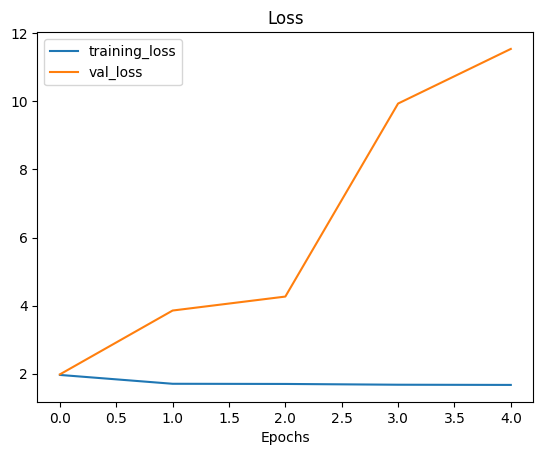

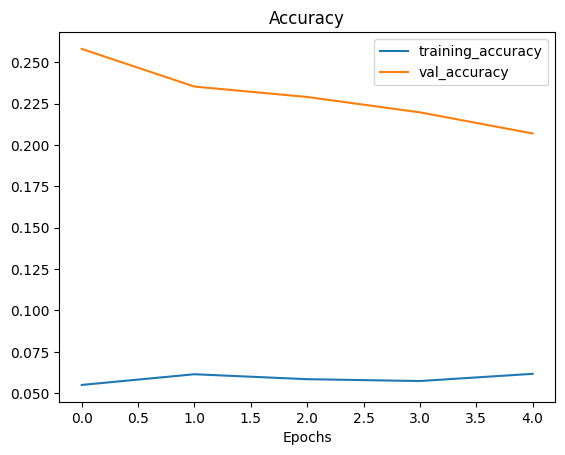

In [65]:
plot_loss_accuracy_curves(model_2_history)

In [66]:
model_2.evaluate(test_ds)

225/225 [==============================] - 7s 30ms/step - loss: 12.5356 - sparse_categorical_accuracy: 0.2116 - sparse_top_k_categorical_accuracy: 0.5971


[12.535642623901367, 0.2116188406944275, 0.5971022844314575]

In [69]:
model_2_path = path_to_models+'model_2.h5'
model_2.save(model_2_path)

### Now lets try it on the augmented dataset using mixup

In [38]:
model_3 = tf.keras.models.clone_model(model_0)
model_3.compile(loss=SparseCategoricalCrossentropy(),
                optimizer=Adam(),
                metrics=metrics)
model_3_history=model_3.fit(training_dataset_mixup,
            epochs=5,
            validation_data=val_ds)

Epoch 1/5
763/763 [==============================] - 83s 93ms/step - loss: 2.2394 - sparse_categorical_accuracy: 0.0532 - sparse_top_k_categorical_accuracy: 0.6721 - val_loss: 128.8255 - val_sparse_categorical_accuracy: 0.2596 - val_sparse_top_k_categorical_accuracy: 0.5745
Epoch 2/5
763/763 [==============================] - 70s 91ms/step - loss: 1.7354 - sparse_categorical_accuracy: 0.0616 - sparse_top_k_categorical_accuracy: 0.7074 - val_loss: 116.7318 - val_sparse_categorical_accuracy: 0.2596 - val_sparse_top_k_categorical_accuracy: 0.5787
Epoch 3/5
763/763 [==============================] - 70s 92ms/step - loss: 1.7296 - sparse_categorical_accuracy: 0.0610 - sparse_top_k_categorical_accuracy: 0.7052 - val_loss: 121.8780 - val_sparse_categorical_accuracy: 0.2599 - val_sparse_top_k_categorical_accuracy: 0.5834
Epoch 4/5
763/763 [==============================] - 70s 92ms/step - loss: 1.7221 - sparse_categorical_accuracy: 0.0586 - sparse_top_k_categorical_accuracy: 0.7070 - val_loss:

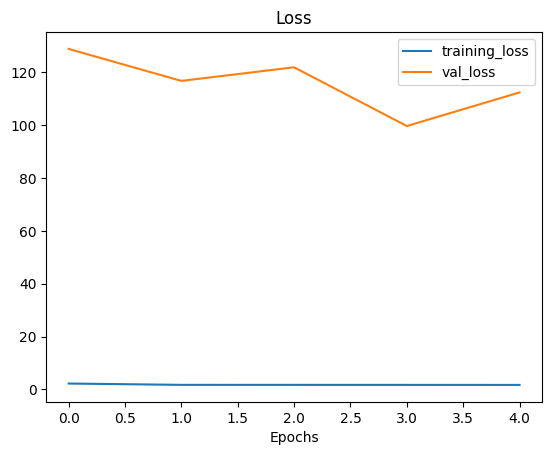

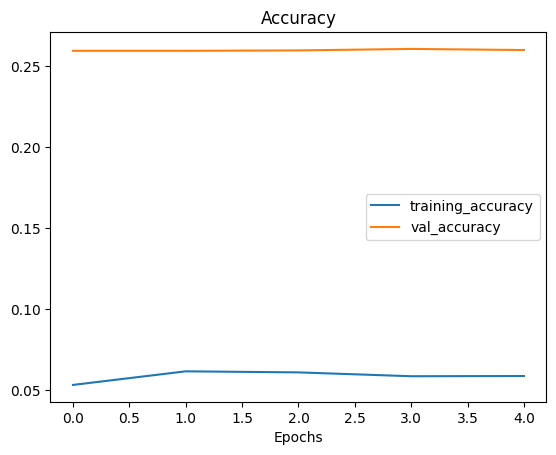

In [39]:
plot_loss_accuracy_curves(model_3_history)

In [40]:
model_3.evaluate(test_ds)

225/225 [==============================] - 7s 31ms/step - loss: 114.7283 - sparse_categorical_accuracy: 0.2491 - sparse_top_k_categorical_accuracy: 0.6953


[114.72831726074219, 0.24909445643424988, 0.6953190565109253]

In [43]:
model_3_path = path_to_models+'model_3.h5'
model_3.save(model_3_path)

## Lenet

In [44]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
       Rescaling(1./255),
])

Dropout layers and l2 regulaizers and batch normalization layers have been added to avoid overfitting as much as possible

In [45]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 127, 127, 64)     0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 127, 127, 64)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 132)    

In [ ]:
lenet_model.compile(
    loss=SparseCategoricalCrossentropy(),
    optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
    metrics=metrics
)

In [ ]:
lenet_model_history=lenet_model.fit(training_dataset_normal_aug,
            epochs=10,
            validation_data=val_ds)

Epoch 1/10
763/763 [==============================] - 65s 75ms/step - loss: 6.6511 - sparse_categorical_accuracy: 0.2899 - sparse_top_k_categorical_accuracy: 0.7014 - val_loss: 310.1284 - val_sparse_categorical_accuracy: 0.2353 - val_sparse_top_k_categorical_accuracy: 0.9166
Epoch 2/10
763/763 [==============================] - 55s 72ms/step - loss: 3.6690 - sparse_categorical_accuracy: 0.2994 - sparse_top_k_categorical_accuracy: 0.6530 - val_loss: 59.4106 - val_sparse_categorical_accuracy: 0.0585 - val_sparse_top_k_categorical_accuracy: 0.2652
Epoch 3/10
763/763 [==============================] - 56s 73ms/step - loss: 3.1226 - sparse_categorical_accuracy: 0.3045 - sparse_top_k_categorical_accuracy: 0.6590 - val_loss: 227.9887 - val_sparse_categorical_accuracy: 0.1570 - val_sparse_top_k_categorical_accuracy: 0.9817
Epoch 4/10
763/763 [==============================] - 56s 72ms/step - loss: 2.9453 - sparse_categorical_accuracy: 0.2992 - sparse_top_k_categorical_accuracy: 0.6541 - val_lo

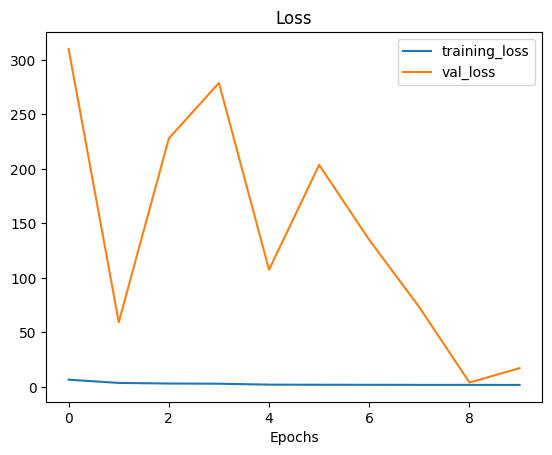

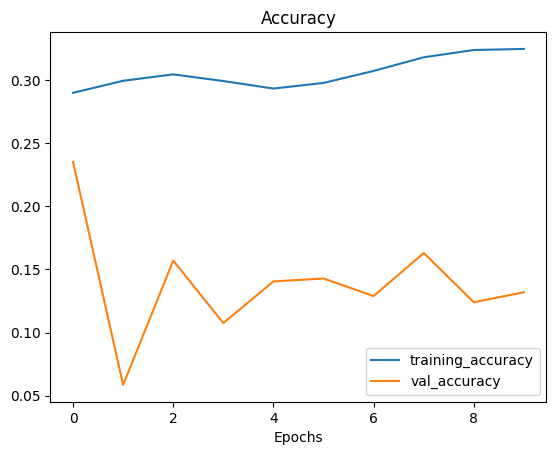

In [ ]:
plot_loss_accuracy_curves(lenet_model_history)

In [ ]:
lenet_model_path = path_to_models+'lenet_model.h5'

In [ ]:
lenet_model.save(lenet_model_path)

In [ ]:
lenet_model_0 = tf.keras.models.clone_model(lenet_model)
lenet_model_0.compile(
    loss=SparseCategoricalCrossentropy(),
    optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
    metrics=metrics
)
lenet_model_0_history=lenet_model_0.fit(training_dataset_normal_aug,
            epochs=10,
            validation_data=val_ds)

Epoch 1/10
763/763 [==============================] - 60s 73ms/step - loss: 5.3791 - sparse_categorical_accuracy: 0.2635 - sparse_top_k_categorical_accuracy: 0.6066 - val_loss: 136.4239 - val_sparse_categorical_accuracy: 0.0193 - val_sparse_top_k_categorical_accuracy: 0.8488
Epoch 2/10
763/763 [==============================] - 56s 73ms/step - loss: 2.0973 - sparse_categorical_accuracy: 0.3074 - sparse_top_k_categorical_accuracy: 0.6568 - val_loss: 11.5412 - val_sparse_categorical_accuracy: 0.1549 - val_sparse_top_k_categorical_accuracy: 0.3888
Epoch 3/10
763/763 [==============================] - 56s 73ms/step - loss: 2.0068 - sparse_categorical_accuracy: 0.3130 - sparse_top_k_categorical_accuracy: 0.6653 - val_loss: 58.5761 - val_sparse_categorical_accuracy: 0.1700 - val_sparse_top_k_categorical_accuracy: 0.4524
Epoch 4/10
763/763 [==============================] - 56s 72ms/step - loss: 1.9591 - sparse_categorical_accuracy: 0.3160 - sparse_top_k_categorical_accuracy: 0.6668 - val_los

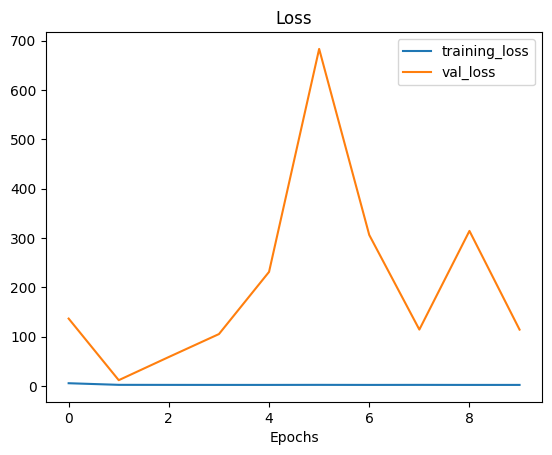

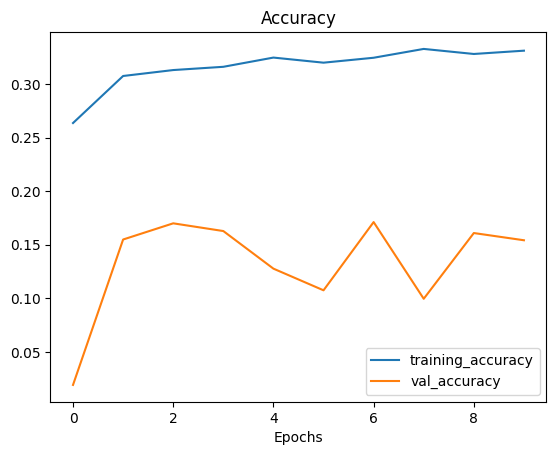

In [ ]:
plot_loss_accuracy_curves(lenet_model_0_history)

In [ ]:
lenet_model_0_path = path_to_models+'lenet_model_0.h5'
lenet_model_0.save(lenet_model_0_path)

In [ ]:
# lenet_model_1 = tf.keras.models.clone_model(lenet_model)
# lenet_model_1.compile(
#     loss=SparseCategoricalCrossentropy(),
#     optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
#     metrics=metrics
# )
# lenet_model_1_history=lenet_model_1.fit(training_dataset_cutmix,
#             epochs=5,
#             validation_data=val_ds)

In [ ]:
# plot_loss_accuracy_curves(lenet_model_1_history)

In [ ]:
# lenet_model_1_path = path_to_models+'lenet_model_1.h5'
# lenet_model_1.save(lenet_model_1_path)

In [ ]:
# lenet_model_2 = tf.keras.models.clone_model(lenet_model)
# lenet_model_2.compile(
#     loss=SparseCategoricalCrossentropy(),
#     optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
#     metrics=metrics
# )
# lenet_model_2_history=lenet_model_2.fit(training_dataset_mixup,
#             epochs=5,
#             validation_data=val_ds)

In [ ]:
# plot_loss_accuracy_curves(lenet_model_2_history)

In [ ]:
# lenet_model_2_path = path_to_models+'lenet_model_2.h5'
# lenet_model_2.save(lenet_model_2_path)

## Resnet34

In [ ]:
class Conv2DAndBatchNorm(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(Conv2DAndBatchNorm, self).__init__(name = 'conv2d_batch_norm')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)

    self.batch_norm = BatchNormalization()
  def call(self,x,training=True):
    x=self.conv(x)
    x=self.batch_norm(x,training)
    return x

In [ ]:
class ResidualBlock(Layer):
  def __init__(self,n_channels, num, n_strides = 1):
    super(ResidualBlock, self).__init__(name = f'residual_block_{num}')

    self.dotted = n_strides!=1

    self.conv_batch_norm_1 = Conv2DAndBatchNorm(n_channels,3,n_strides,"same")
    self.conv_batch_norm_2 = Conv2DAndBatchNorm(n_channels,3,1,"same")

    self.activation = Activation('relu')

    if self.dotted:
      self.conv_batch_norm_3 = Conv2DAndBatchNorm(n_channels,1,n_strides)

  def call(self,input,training=True):
    x=self.conv_batch_norm_1(input,training)
    x=self.conv_batch_norm_2(x,training)

    if self.dotted:
      x_input=self.conv_batch_norm_3(input,training)
      x = Add()([x,x_input])
    else:
      x = Add()([x,input])

    return self.activation(x)


In [ ]:
class ResNet34(Model):
  def __init__(self):
    super(ResNet34,self).__init__(name='resnet_model')

    self.conv_1 = Conv2DAndBatchNorm(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)

    self.conv_2_1 = ResidualBlock(64,1)
    self.conv_2_2 = ResidualBlock(64,2)
    self.conv_2_3 = ResidualBlock(64,3)

    self.conv_3_1 = ResidualBlock(128,4, 2)
    self.conv_3_2 = ResidualBlock(128,5)
    self.conv_3_3 = ResidualBlock(128,6)
    self.conv_3_4 = ResidualBlock(128,7)

    self.conv_4_1 = ResidualBlock(256,8, 2)
    self.conv_4_2 = ResidualBlock(256,9)
    self.conv_4_3 = ResidualBlock(256,10)
    self.conv_4_4 = ResidualBlock(256,11)
    self.conv_4_5 = ResidualBlock(256,12)
    self.conv_4_6 = ResidualBlock(256,13)

    self.conv_5_1 = ResidualBlock(512, 14,2)
    self.conv_5_2 = ResidualBlock(512,15)
    self.conv_5_3 = ResidualBlock(512,16)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')

  def call(self,input,training=True):
    x = resize_rescale_layers(input)
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training)
    x = self.conv_2_2(x, training)
    x = self.conv_2_3(x, training)

    x = self.conv_3_1(x, training)
    x = self.conv_3_2(x, training)
    x = self.conv_3_3(x, training)
    x = self.conv_3_4(x, training)

    x = self.conv_4_1(x, training)
    x = self.conv_4_2(x, training)
    x = self.conv_4_3(x, training)
    x = self.conv_4_4(x, training)
    x = self.conv_4_5(x, training)
    x = self.conv_4_6(x, training)

    x = self.conv_5_1(x, training)
    x = self.conv_5_2(x, training)
    x = self.conv_5_3(x, training)

    x = self.global_pool(x)

    return self.fc_3(x)

  def build_graph(self):
    x = Input(shape=(None,None,3))
    return Model(inputs=[x], outputs=self.call(x))


In [ ]:
resnet34 = ResNet34()
resnet34.build(input_shape=(1,300,500,3))

In [ ]:
resnet34.build_graph().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_batch_norm (Conv2DAn  (None, 128, 128, 64)     9728      
 dBatchNorm)                                                     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 residual_block_1 (ResidualB  (None, 63, 63, 64)       74368     
 lock)                                                           
                                                             

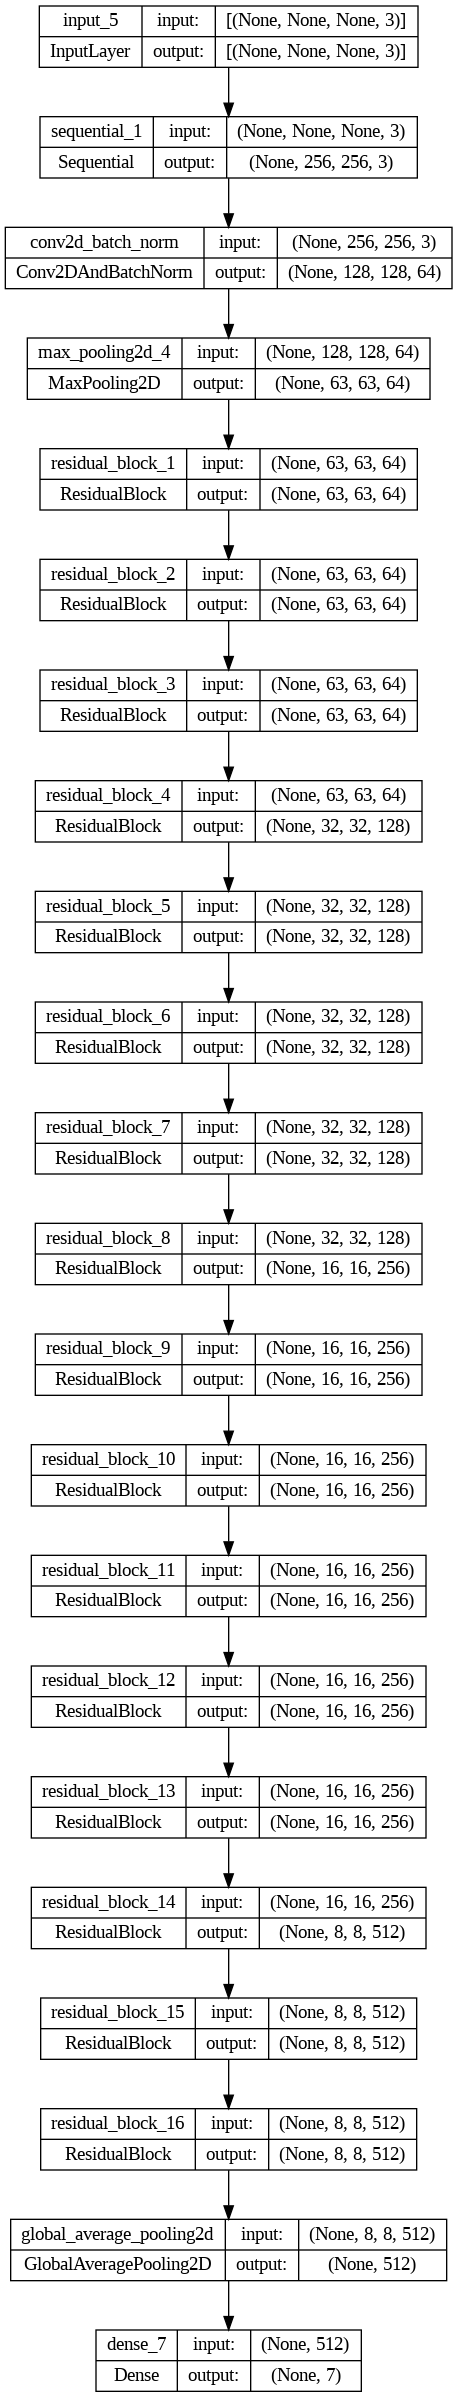

In [ ]:
plot_model(resnet34.build_graph(),show_shapes=True, show_layer_names=True,)

In [ ]:
resnet34.compile(
    loss=SparseCategoricalCrossentropy(),
    optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
    metrics=metrics
)
resnet34_history=resnet34.fit(
    train_ds_normal,
    epochs=5,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/5
763/763 [==============================] - 64s 51ms/step - loss: 1.7626 - sparse_categorical_accuracy: 0.1881 - sparse_top_k_categorical_accuracy: 0.6325 - val_loss: 2.2655 - val_sparse_categorical_accuracy: 0.3760 - val_sparse_top_k_categorical_accuracy: 0.7183 - lr: 0.0010
Epoch 2/5
763/763 [==============================] - 37s 49ms/step - loss: 1.4520 - sparse_categorical_accuracy: 0.4484 - sparse_top_k_categorical_accuracy: 0.7880 - val_loss: 2.2500 - val_sparse_categorical_accuracy: 0.3423 - val_sparse_top_k_categorical_accuracy: 0.6670 - lr: 0.0010
Epoch 3/5
763/763 [==============================] - 37s 49ms/step - loss: 1.3010 - sparse_categorical_accuracy: 0.5124 - sparse_top_k_categorical_accuracy: 0.8349 - val_loss: 3.8089 - val_sparse_categorical_accuracy: 0.3964 - val_sparse_top_k_categorical_accuracy: 0.7276 - lr: 0.0010
Epoch 4/5
763/763 [==============================] - 37s 49ms/step - loss: 1.2028 - sparse_categorical_accuracy: 0.5518 - sparse_top_k_categor

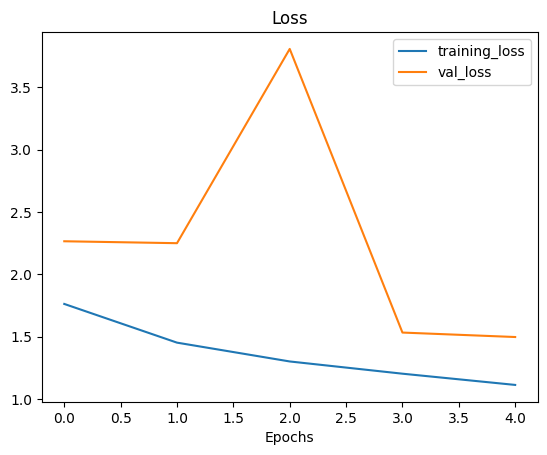

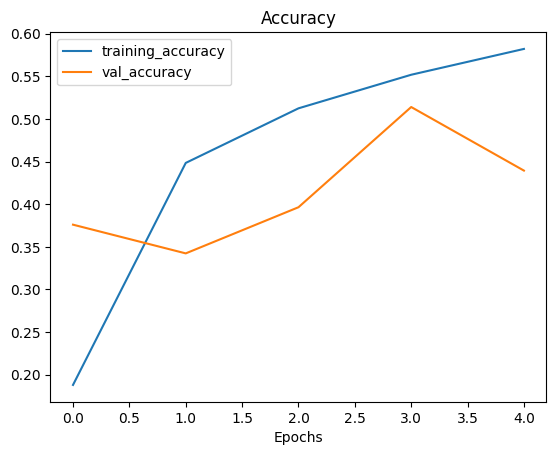

In [ ]:
plot_loss_accuracy_curves(resnet34_history)

In [ ]:
resnet34_path = path_to_models+'resnet34/resnet34'

In [ ]:
resnet34.save_weights(resnet34_path)

In [ ]:
resnet34_0 = ResNet34()
resnet34_0.compile(
    loss=SparseCategoricalCrossentropy(),
    optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
    metrics=metrics
)
resnet34_0_history=resnet34_0.fit(
    training_dataset_normal_aug,
    epochs=5,
    validation_data=val_ds,
    callbacks=callbacks,
)

Epoch 1/5
763/763 [==============================] - 73s 59ms/step - loss: 1.7614 - sparse_categorical_accuracy: 0.2971 - sparse_top_k_categorical_accuracy: 0.6860 - val_loss: 20558.9863 - val_sparse_categorical_accuracy: 0.1075 - val_sparse_top_k_categorical_accuracy: 0.9995 - lr: 0.0010
Epoch 2/5
763/763 [==============================] - 44s 57ms/step - loss: 1.4497 - sparse_categorical_accuracy: 0.4452 - sparse_top_k_categorical_accuracy: 0.7868 - val_loss: 12428.5859 - val_sparse_categorical_accuracy: 0.1075 - val_sparse_top_k_categorical_accuracy: 0.9995 - lr: 0.0010
Epoch 3/5
763/763 [==============================] - 44s 57ms/step - loss: 1.3021 - sparse_categorical_accuracy: 0.5019 - sparse_top_k_categorical_accuracy: 0.8308 - val_loss: 19952.2090 - val_sparse_categorical_accuracy: 0.1403 - val_sparse_top_k_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 4/5
763/763 [==============================] - 43s 56ms/step - loss: 1.2142 - sparse_categorical_accuracy: 0.5414 - sparse_t

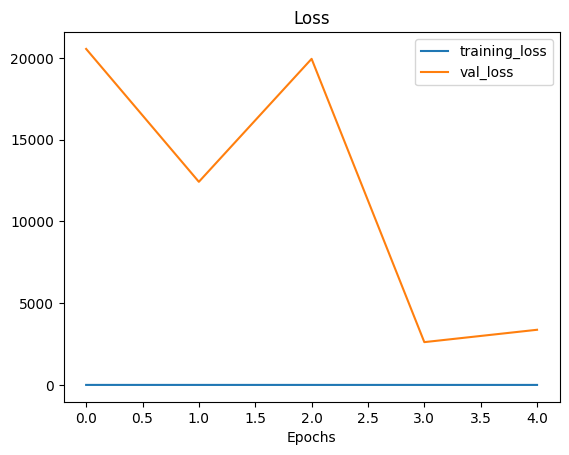

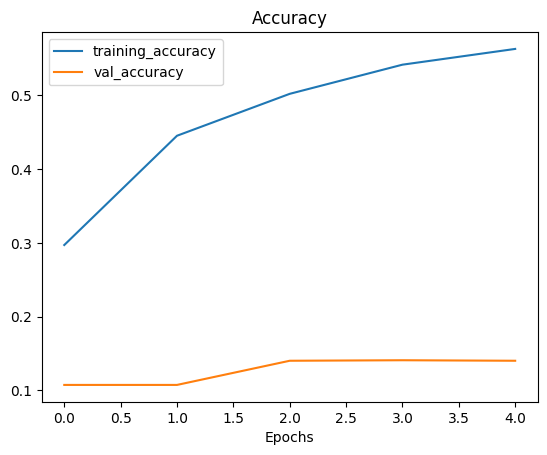

In [ ]:
plot_loss_accuracy_curves(resnet34_0_history)

In [ ]:
resnet34_0_path = path_to_models+'resnet34_0/resnet34_0'

In [ ]:
resnet34_0.save_weights(resnet34_0_path)

In [ ]:
# resnet34_1 = ResNet34()
# resnet34_1.compile(
#     loss=SparseCategoricalCrossentropy(),
#     optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
#     metrics=metrics
# )
# resnet34_1_history=resnet34_1.fit(
#     training_dataset_cutmix,
#     epochs=5,
#     validation_data=val_ds,
#     callbacks=callbacks
# )

In [ ]:
# plot_loss_accuracy_curves(resnet34_1_history)

In [ ]:
# resnet34_2 = ResNet34()
# resnet34_2.compile(
#     loss=SparseCategoricalCrossentropy(),
#     optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
#     metrics=metrics
# )
# resnet34_2_history=resnet34_2.fit(
#     training_dataset_mixup,
#     epochs=5,
#     validation_data=val_ds,
#     callbacks=callbacks
# )

In [ ]:
# plot_loss_accuracy_curves(resnet34_2_history)

# Transfer Learning with MobilenetV2

Why we are using MobilenetV2?


*  Because it is fun to explore new models 🙂
*  It uses inverted residual architecture in which inputs are small at first then gets expanded then becomes small again to be transported easily across networks
*   It uses depthwise convolution as well as poinwise convolutions and this definitely decreases the model parameters drastically so the model becomes much more efficient to train






In [ ]:
backbone = tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top = False,
    weights='imagenet',
    input_shape=(None, None, 3),
)

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
for layer in backbone.layers:
  print(layer)

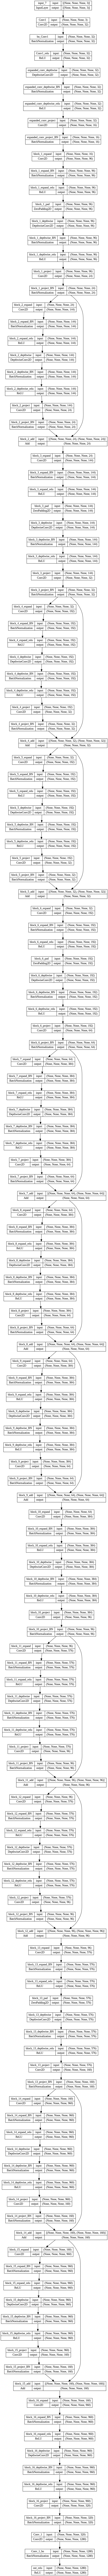

In [ ]:
plot_model(backbone,show_shapes=True, show_layer_names=True)



What's the difference between 2 attributes training and trainable?

trainable:- ( If True ) It basically implies that the "trainable" weights of the parameter( of the layer ) will be updated in backpropagation.

training:- Some layers perform differently at training and inference( or testing ) steps. Some examples include Dropout Layer, Batch-Normalization layers. So this attribute tells the layer that in what manner it should perform.

Is gamma and beta getting updated in the training process if set trainable to false?

Since gamma and beta are "trainable" parameters of the BN Layer, they will NOT be updated in the training process if set trainable is set to "False".

Why is it necessary to set trainable to false when fine-tuning?

When doing fine-tuning, we first add our own classification FC layer at the top which is randomly initialized but our "pre-trained" model is already calibrated( a bit ) for the task.

As an analogy, think like this.

You have a number line from 0 - 10. On this number line, '0' represents a completely randomized model whereas '10' represents a kind of perfect model. Our pre-trained model is somewhere around 5 or maybe 6 or maybe 7 i.e. most probably better than a random model. The FC Layer we have added at the top is at '0' as it is randomized at the start.

We set trainable = False for the pre-trained model so that we can make the FC Layer reach the level of the pre-trained model rapidly i.e. with a higher learning rate. If we don't set trainable = False for the pre-trained model and use a higher learning rate then it will wreak havoc.

So initially, we set a higher learning rate and trainable = False for the pre-trained model and train the FC layer. After that, we unfreeze our pre-trained model and use a very low learning rate to serve our purpose.

To see more: https://stackoverflow.com/questions/62729806/whats-the-difference-between-attrubutes-trainable-and-training-in-batchnorm

In [ ]:
def create_pretrained_model(backbone,trainable=False):

  backbone.trainable=trainable

  input = Input(shape = (None, None,3))
  x = resize_rescale_layers(input)
  x = backbone(x, training = False)
  x = GlobalAveragePooling2D()(x)
  x = Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
  x = BatchNormalization()(x)
  x = Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
  output = Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)

  pretrained_model = Model(input, output)
  return pretrained_model

pretrained_model = create_pretrained_model(backbone, False)
pretrained_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096  

Let's run the model with high learning weight to help our newly added layers learn much quicker

In [ ]:
pretrained_model.compile(
    loss=SparseCategoricalCrossentropy(),
    optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
    metrics=metrics
)

In [ ]:
pretrained_model_history=pretrained_model.fit(
    train_ds_normal,
    epochs=7,
    validation_data=val_ds,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/7
763/763 [==============================] - 48s 63ms/step - loss: 10.4241 - sparse_categorical_accuracy: 0.4389 - sparse_top_k_categorical_accuracy: 0.7788 - val_loss: 1.4636 - val_sparse_categorical_accuracy: 0.4480 - val_sparse_top_k_categorical_accuracy: 0.7861 - lr: 0.0010
Epoch 2/7
763/763 [==============================] - 46s 60ms/step - loss: 8.9414 - sparse_categorical_accuracy: 0.5012 - sparse_top_k_categorical_accuracy: 0.8232 - val_loss: 1.4256 - val_sparse_categorical_accuracy: 0.4770 - val_sparse_top_k_categorical_accuracy: 0.8003 - lr: 0.0010
Epoch 3/7
763/763 [==============================] - 47s 61ms/step - loss: 8.0136 - sparse_categorical_accuracy: 0.5384 - sparse_top_k_categorical_accuracy: 0.8502 - val_loss: 1.4793 - val_sparse_categorical_accuracy: 0.4654 - val_sparse_top_k_categorical_accuracy: 0.7952 - lr: 0.0010
Epoch 4/7
762/763 [============================>.] - ETA: 0s - loss: 7.5102 - sparse_categorical_accuracy: 0.5625 - sparse_top_k_categorical_

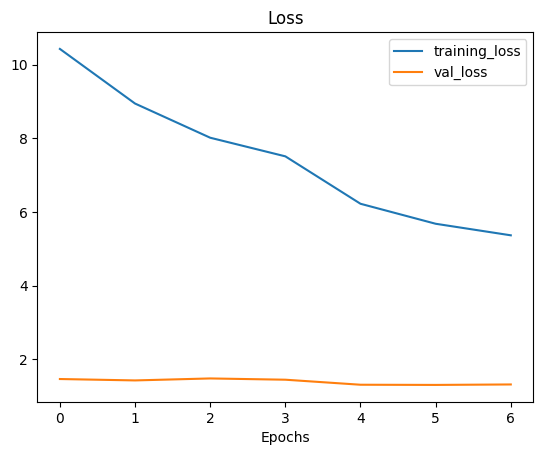

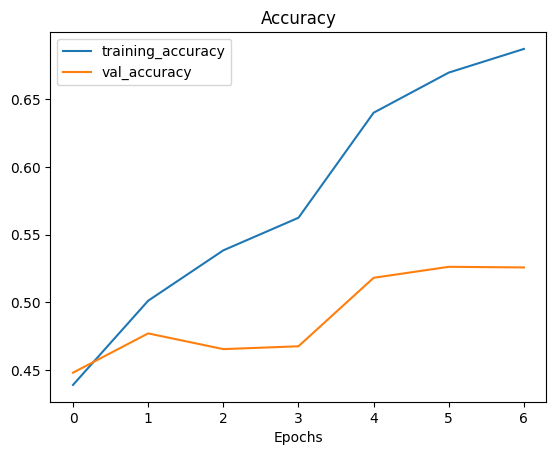

In [ ]:
plot_loss_accuracy_curves(pretrained_model_history)

## Fine Tuning
Let's fine tune the model to see if performance enhances and decrease the learning rate to avoid strong deviations of the weights of the pretrained model

In [ ]:
backbone.trainable = True

In [ ]:
for layer in backbone.layers[:-15]:
  layer.trainable=False
for layer in backbone.layers:
  print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
pretrained_model.compile(
    loss=SparseCategoricalCrossentropy(),
    optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
    metrics=metrics
)

In [ ]:
initial_epochs = pretrained_model_history.epoch[-1]
finetune_epochs = initial_epochs+10

finetuned_model_history=pretrained_model.fit(
    train_ds_normal,
    initial_epoch = pretrained_model_history.epoch[-1],
    epochs=finetune_epochs,
    validation_data=val_ds,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 7/16
763/763 [==============================] - 58s 67ms/step - loss: 13.5942 - sparse_categorical_accuracy: 0.1985 - sparse_top_k_categorical_accuracy: 0.5319 - val_loss: 1.8938 - val_sparse_categorical_accuracy: 0.1363 - val_sparse_top_k_categorical_accuracy: 0.5634 - lr: 0.0010
Epoch 8/16
763/763 [==============================] - 50s 66ms/step - loss: 13.5923 - sparse_categorical_accuracy: 0.1362 - sparse_top_k_categorical_accuracy: 0.4669 - val_loss: 1.9425 - val_sparse_categorical_accuracy: 0.1403 - val_sparse_top_k_categorical_accuracy: 0.3841 - lr: 0.0010
Epoch 9/16
762/763 [============================>.] - ETA: 0s - loss: 13.5937 - sparse_categorical_accuracy: 0.1402 - sparse_top_k_categorical_accuracy: 0.4575
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
763/763 [==============================] - 50s 66ms/step - loss: 13.5923 - sparse_categorical_accuracy: 0.1401 - sparse_top_k_categorical_accuracy: 0.4574 - val_loss: 1.9430 - val_sparse_

In [ ]:
pretrained_model.evaluate(test_ds)

In [ ]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["sparse_categorical_accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_sparse_categorical_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["sparse_categorical_accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_sparse_categorical_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

7
17
[0.4389214515686035, 0.501167893409729, 0.538417398929596, 0.5625128149986267, 0.6401671767234802, 0.6698356866836548, 0.6873335242271423, 0.1985434740781784, 0.13617178797721863, 0.14014670252799988, 0.14313814043998718, 0.14313814043998718, 0.14313814043998718, 0.14313814043998718, 0.14313814043998718, 0.14313814043998718, 0.14313814043998718]


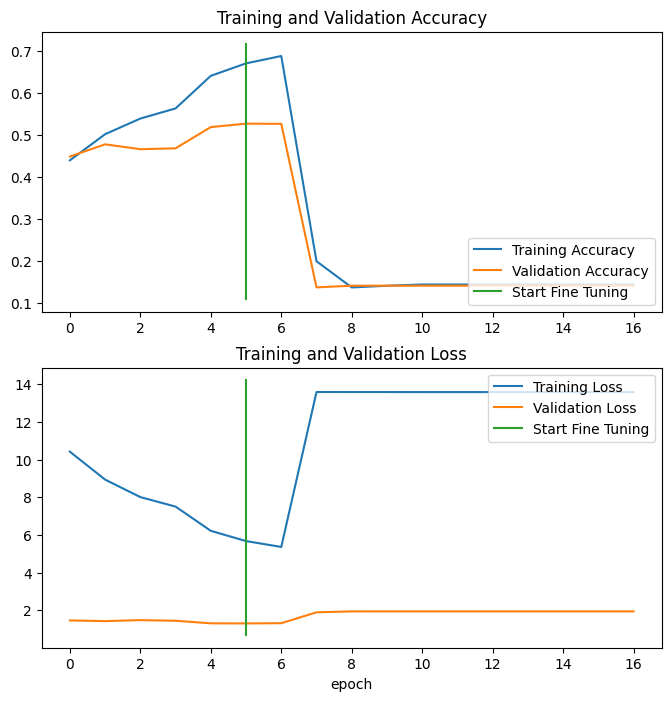

In [ ]:
compare_historys(pretrained_model_history,finetuned_model_history,initial_epochs)

##Ensembling

In [ ]:
resnet34 = ResNet34()
resnet34.load_weights(resnet34_0_path)

In [ ]:
lenet_model=tf.keras.models.load_model(lenet_model_path)

In [ ]:
inputs = Input(shape = (None,None, 3))
x = resize_rescale_layers(inputs)
y_1 = resnet34(x)
y_2 = pretrained_model(x)
y_3 = lenet_model(x)
output = (1/3.)*y_1 + (1/3.)*y_2+(1/3.)*y_3

ensemble_model = Model(inputs = inputs, outputs = output)

ensemble_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 sequential (Sequential)        (None, 256, 256, 3)  0           ['input_5[0][0]']                
                                                                                                  
 resnet_model (ResNet34)        (None, 7)            21313799    ['sequential[2][0]']             
                                                                                                  
 model (Functional)             (None, 7)            3705927     ['sequential[2][0]']       

In [ ]:
ensemble_model.compile(
    loss=SparseCategoricalCrossentropy(),
    optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
    metrics=metrics
)

In [ ]:
ensemble_model.evaluate(test_ds)

225/225 [==============================] - 38s 155ms/step - loss: 1.6040 - sparse_categorical_accuracy: 0.3778 - sparse_top_k_categorical_accuracy: 0.6488


[1.6040172576904297, 0.37783002853393555, 0.6488157510757446]

# Visualization of intermediate layers

## Feature Map Visualization

In [ ]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3),
)

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
def is_conv(layer_name):
  if 'conv' in layer_name.lower().strip():
    return True
  else:
    return False

In [ ]:
feature_maps = [layer.output for layer in base_model.layers[1:] if is_conv(layer.name)]
feature_maps

[<KerasTensor: shape=(None, 128, 128, 32) dtype=float32 (created by layer 'Conv1')>,
 <KerasTensor: shape=(None, 128, 128, 32) dtype=float32 (created by layer 'bn_Conv1')>,
 <KerasTensor: shape=(None, 128, 128, 32) dtype=float32 (created by layer 'Conv1_relu')>,
 <KerasTensor: shape=(None, 128, 128, 32) dtype=float32 (created by layer 'expanded_conv_depthwise')>,
 <KerasTensor: shape=(None, 128, 128, 32) dtype=float32 (created by layer 'expanded_conv_depthwise_BN')>,
 <KerasTensor: shape=(None, 128, 128, 32) dtype=float32 (created by layer 'expanded_conv_depthwise_relu')>,
 <KerasTensor: shape=(None, 128, 128, 16) dtype=float32 (created by layer 'expanded_conv_project')>,
 <KerasTensor: shape=(None, 128, 128, 16) dtype=float32 (created by layer 'expanded_conv_project_BN')>,
 <KerasTensor: shape=(None, 8, 8, 1280) dtype=float32 (created by layer 'Conv_1')>,
 <KerasTensor: shape=(None, 8, 8, 1280) dtype=float32 (created by layer 'Conv_1_bn')>]

In [ ]:
feature_maps_model = Model(inputs=base_model.input, outputs=feature_maps)
feature_maps_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                                           

1/1 [==============================] - 1s 1s/step


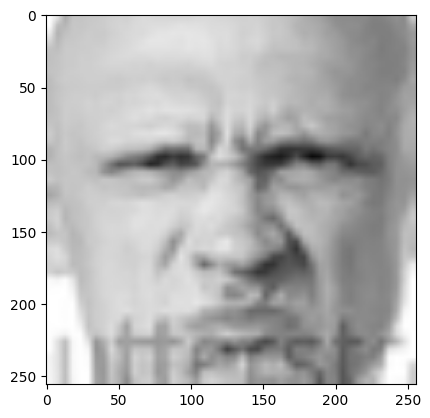

In [ ]:
test_image = cv2.imread("/content/emotion-detection/test/disgusted/im100.png")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))
plt.imshow(test_image)
im = tf.constant(test_image, dtype = tf.float32)
im = tf.expand_dims(im, axis = 0)

f_maps = feature_maps_model.predict(im)

In [ ]:
len(f_maps)

10

In [ ]:
for i in range(len(f_maps)):
  print(f_maps[i].shape)

(1, 128, 128, 32)
(1, 128, 128, 32)
(1, 128, 128, 32)
(1, 128, 128, 32)
(1, 128, 128, 32)
(1, 128, 128, 32)
(1, 128, 128, 16)
(1, 128, 128, 16)
(1, 8, 8, 1280)
(1, 8, 8, 1280)


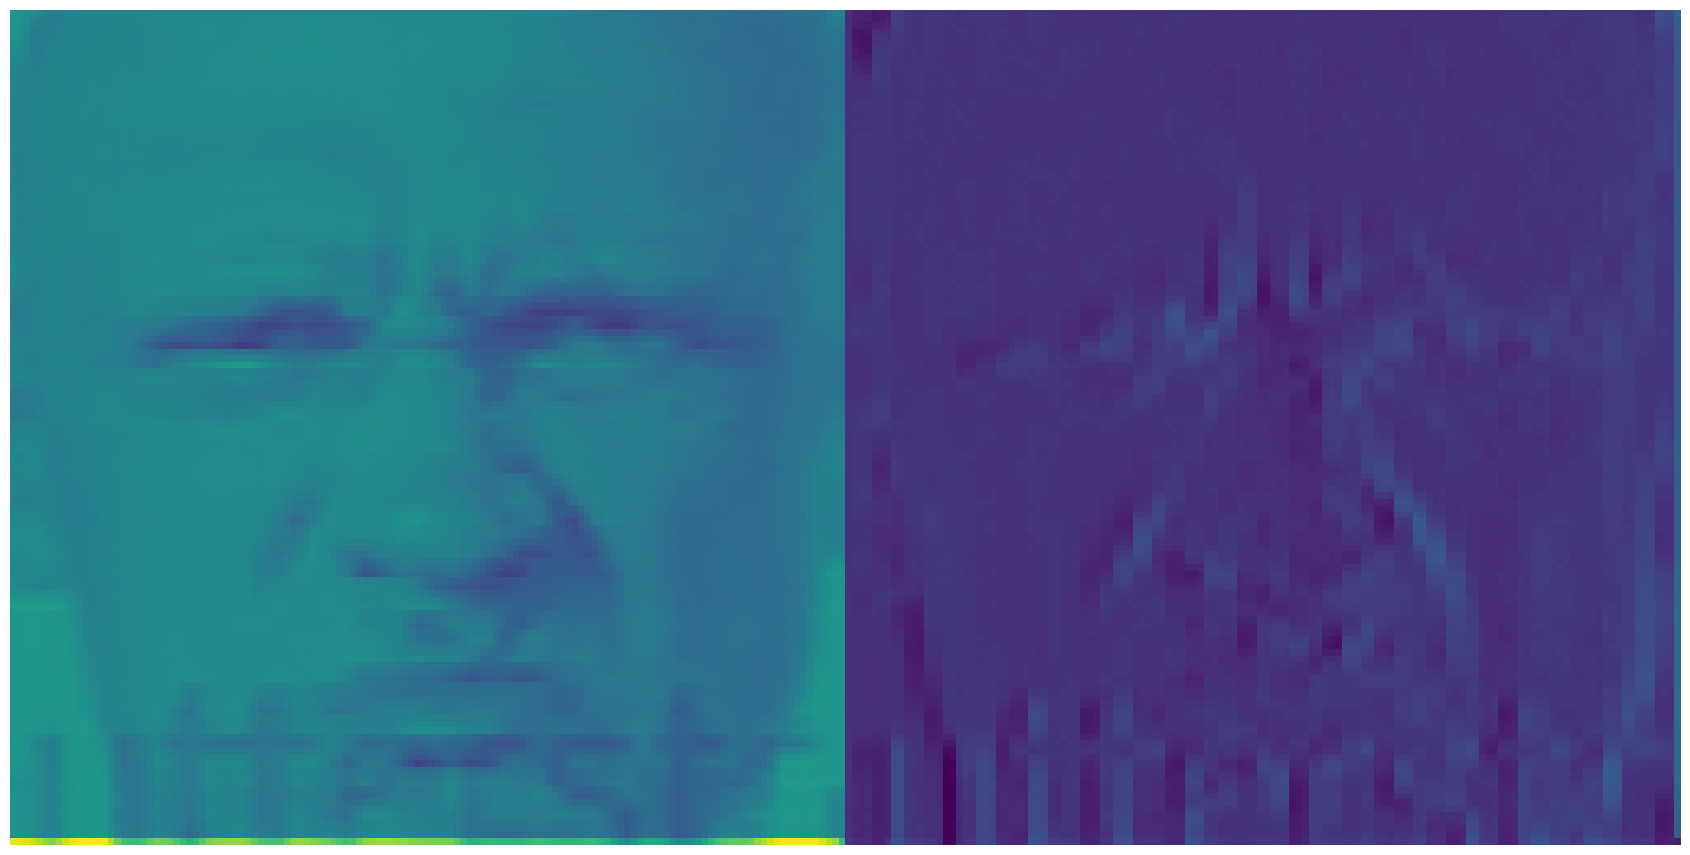

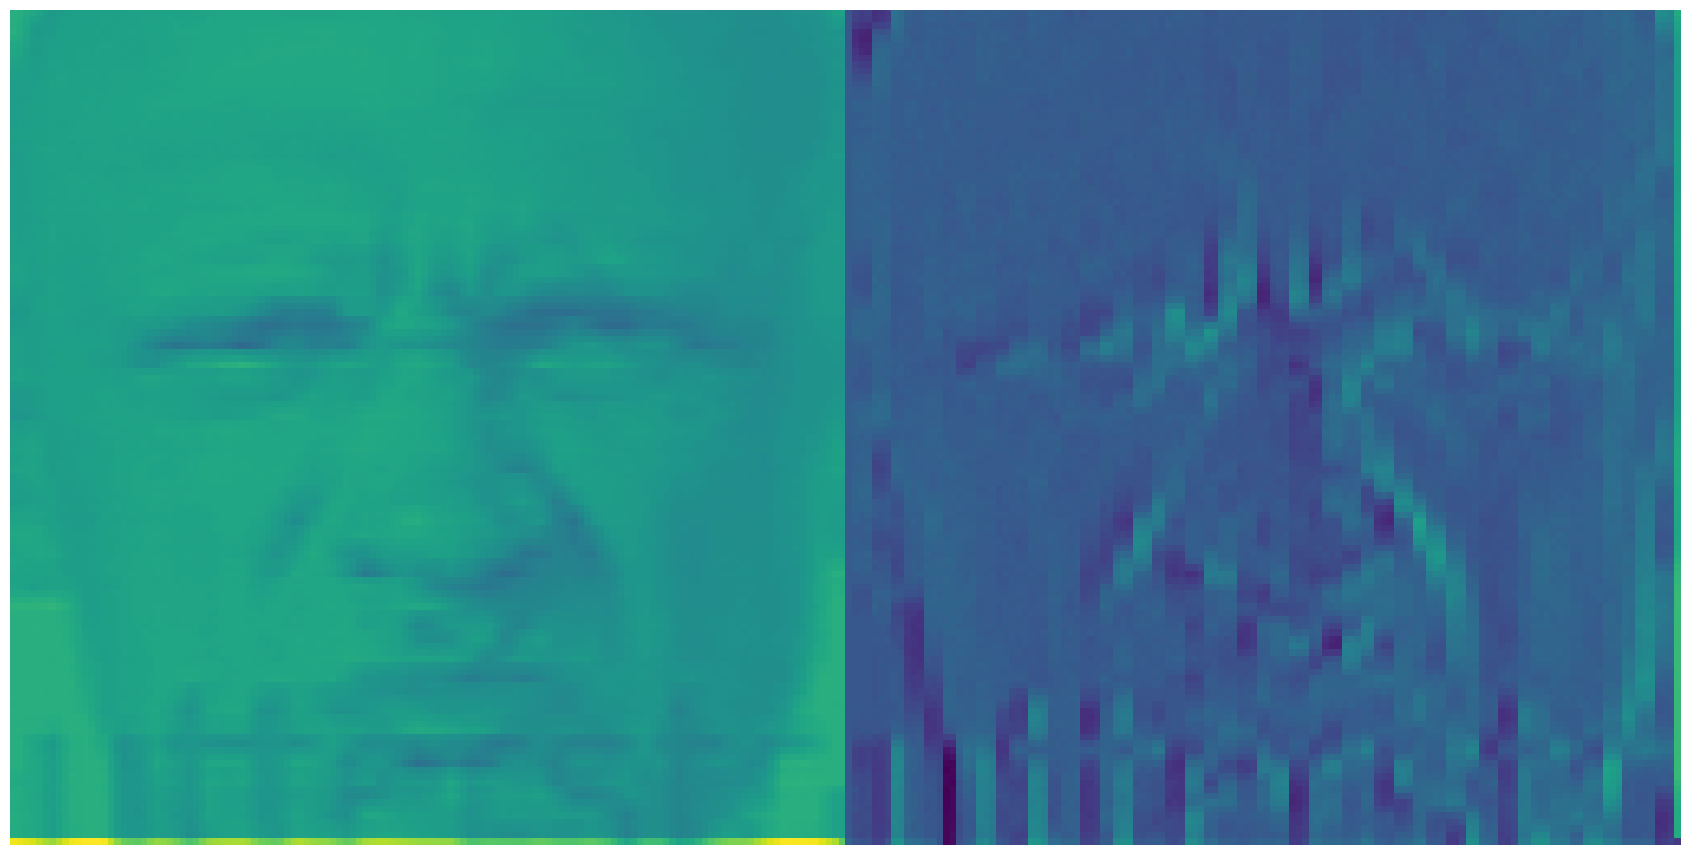

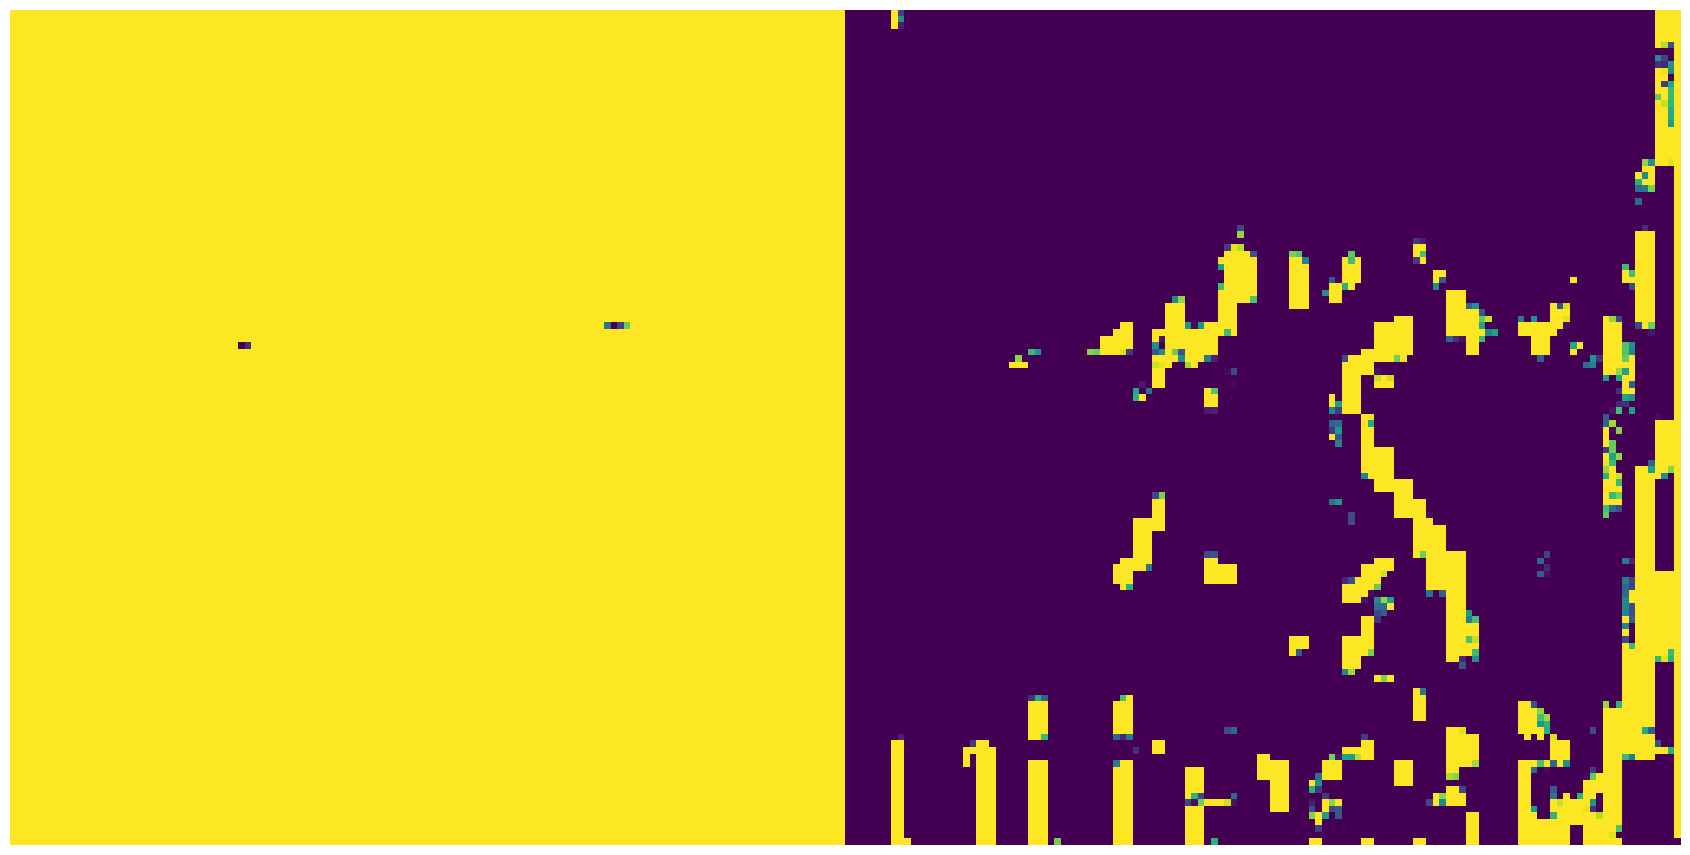

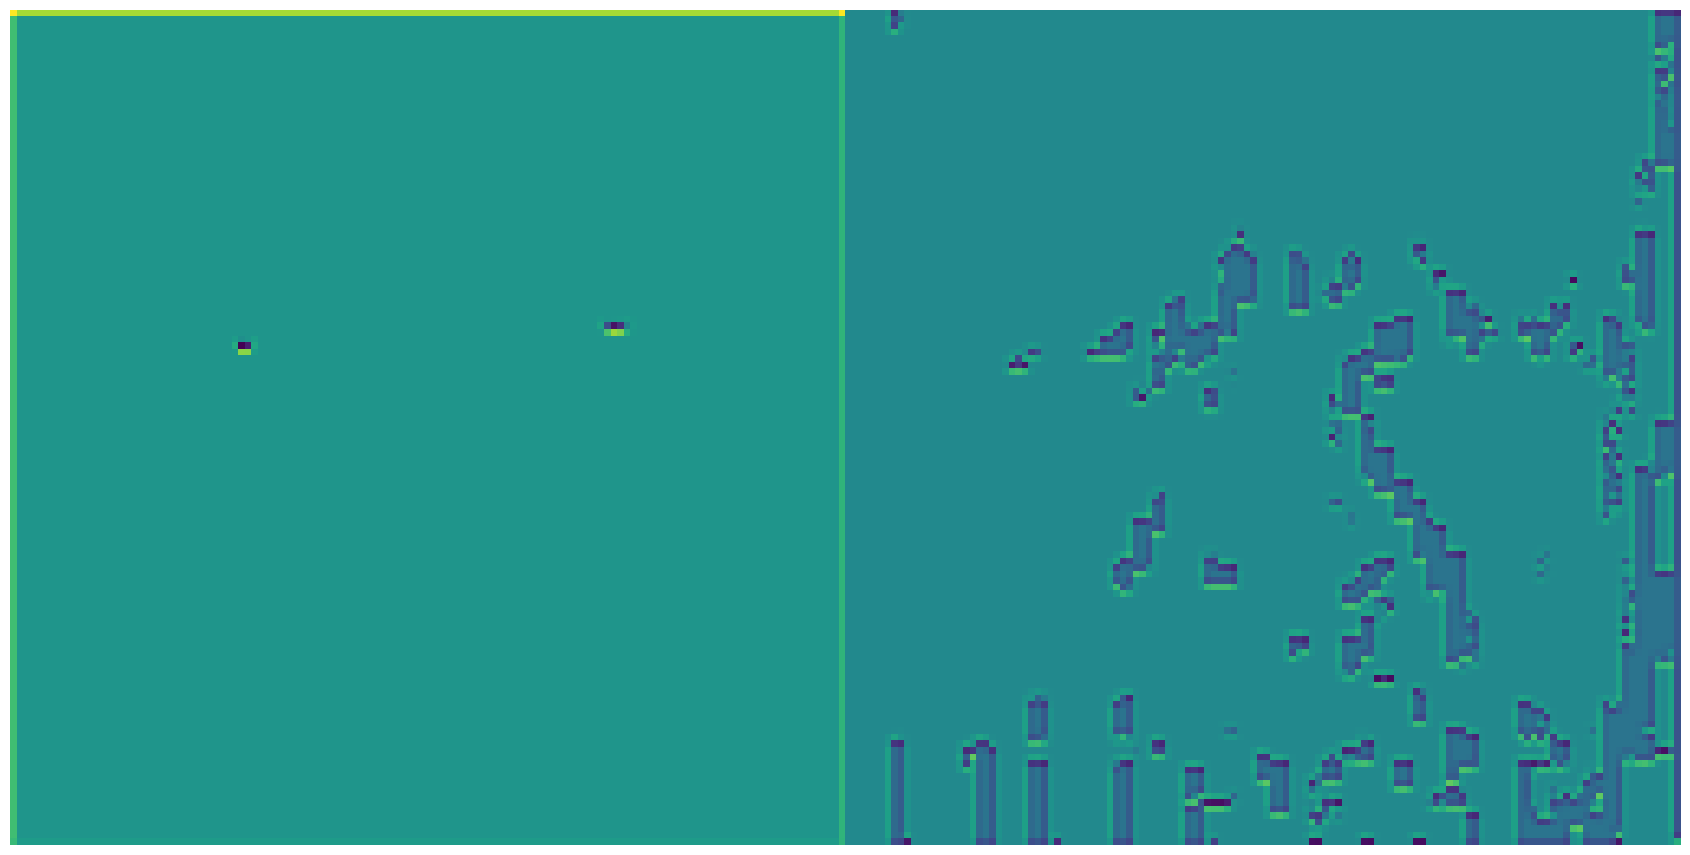

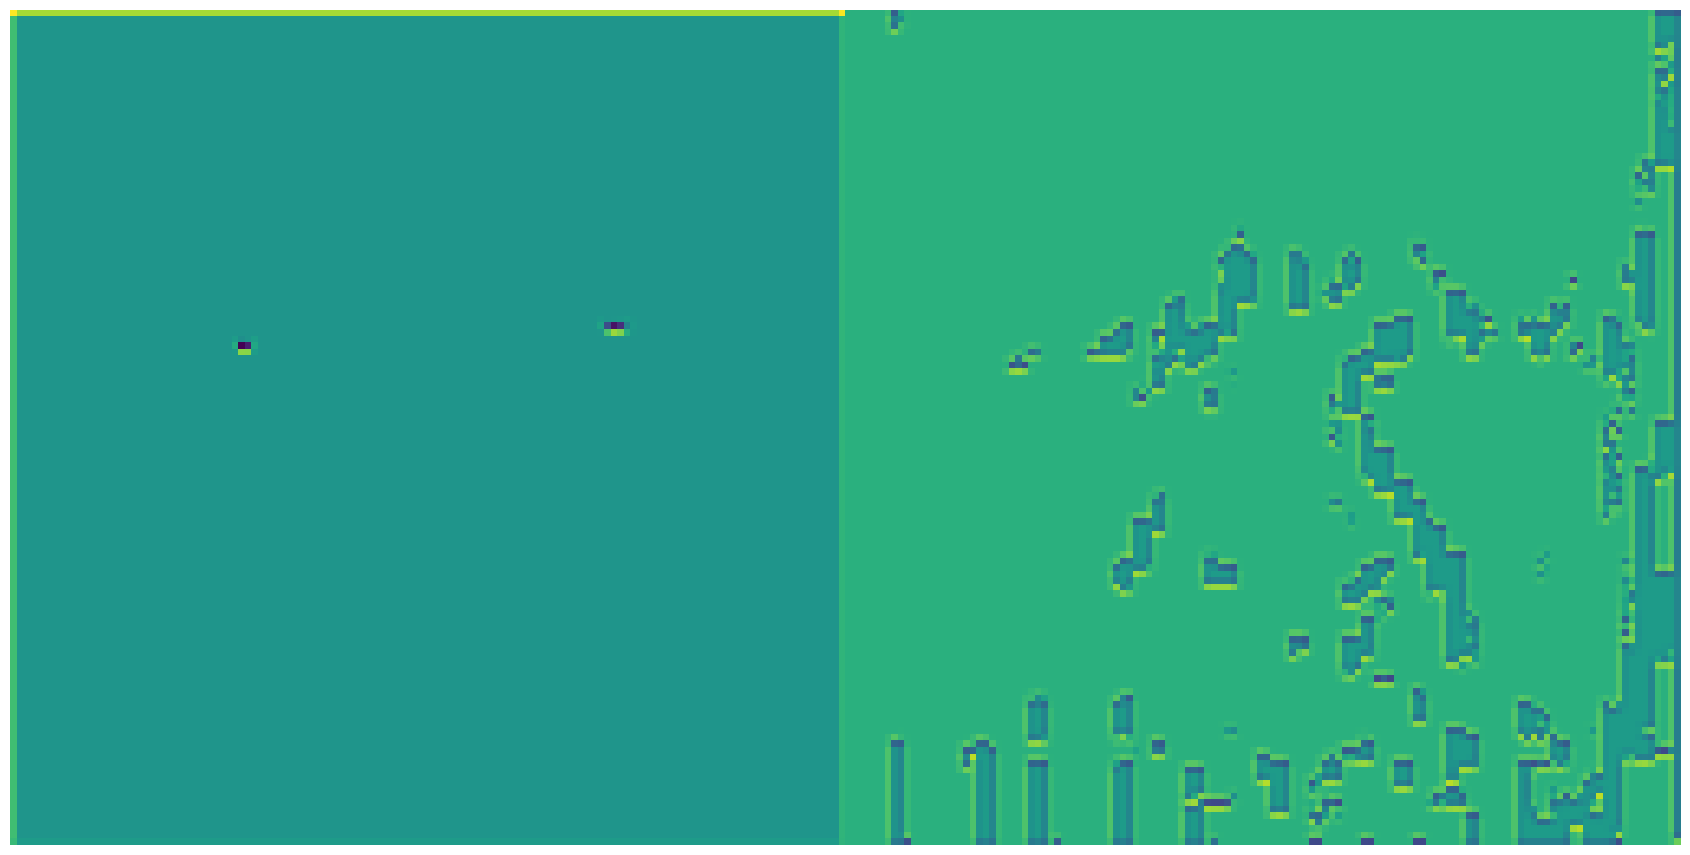

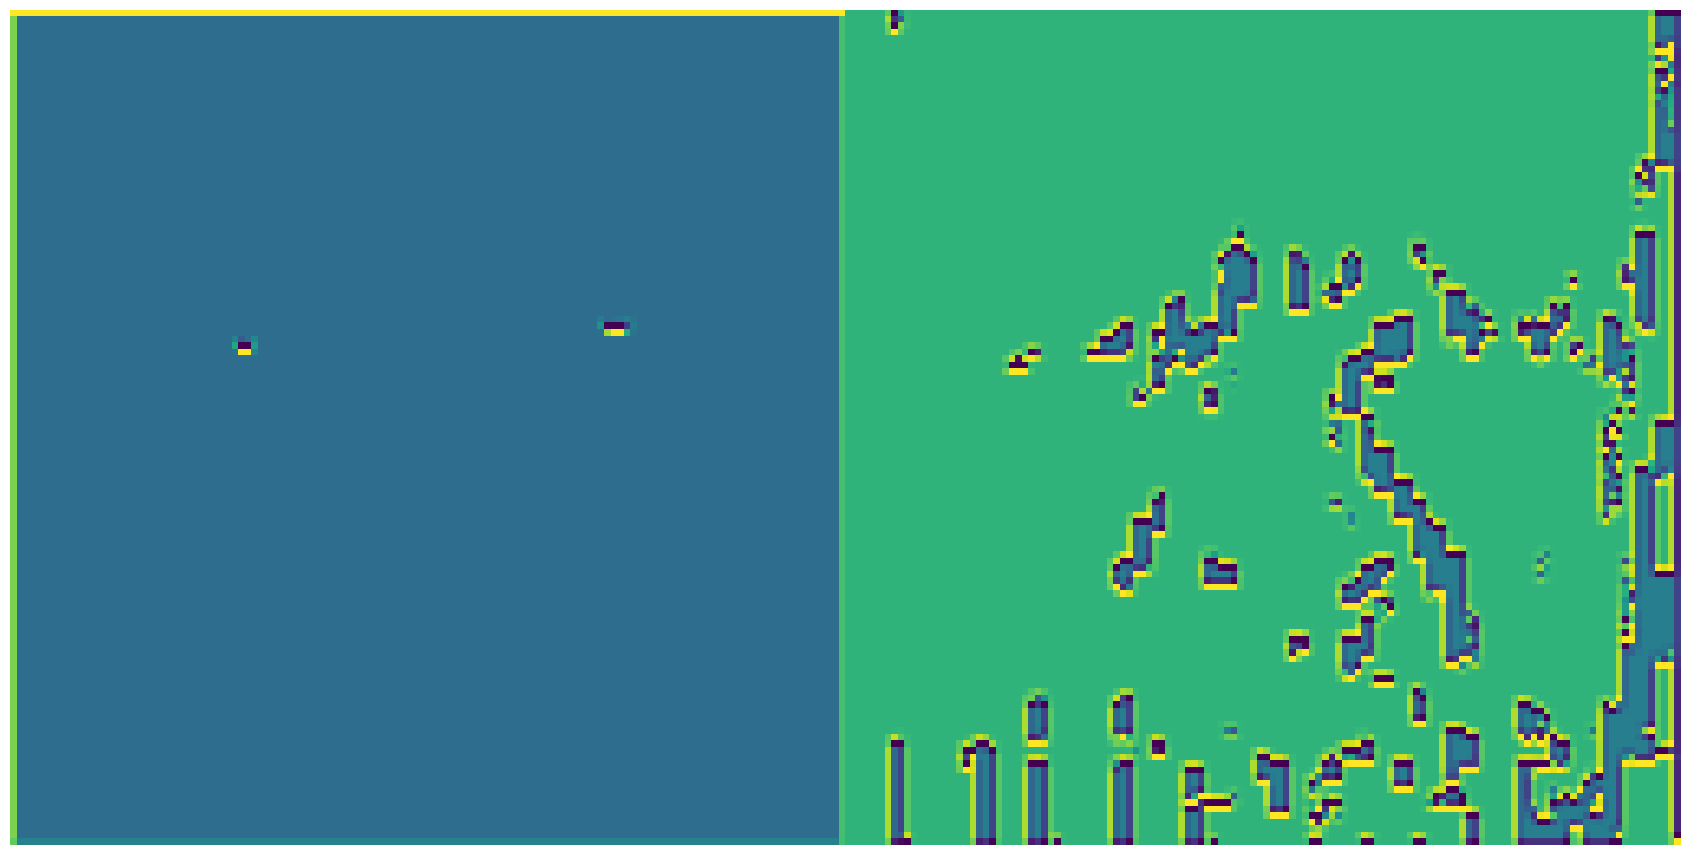

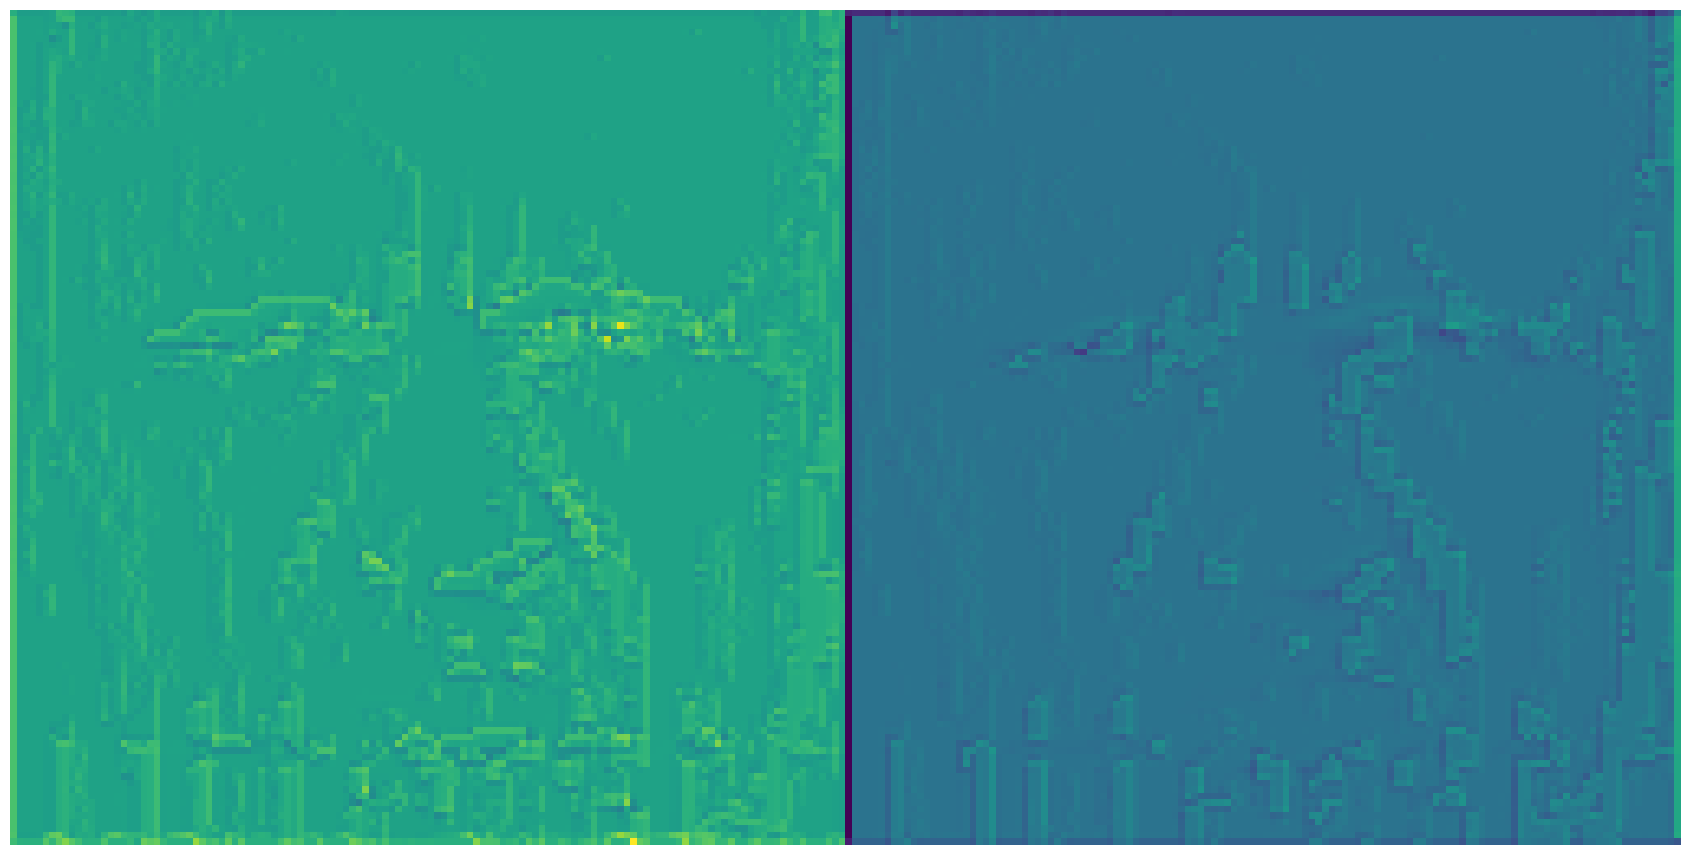

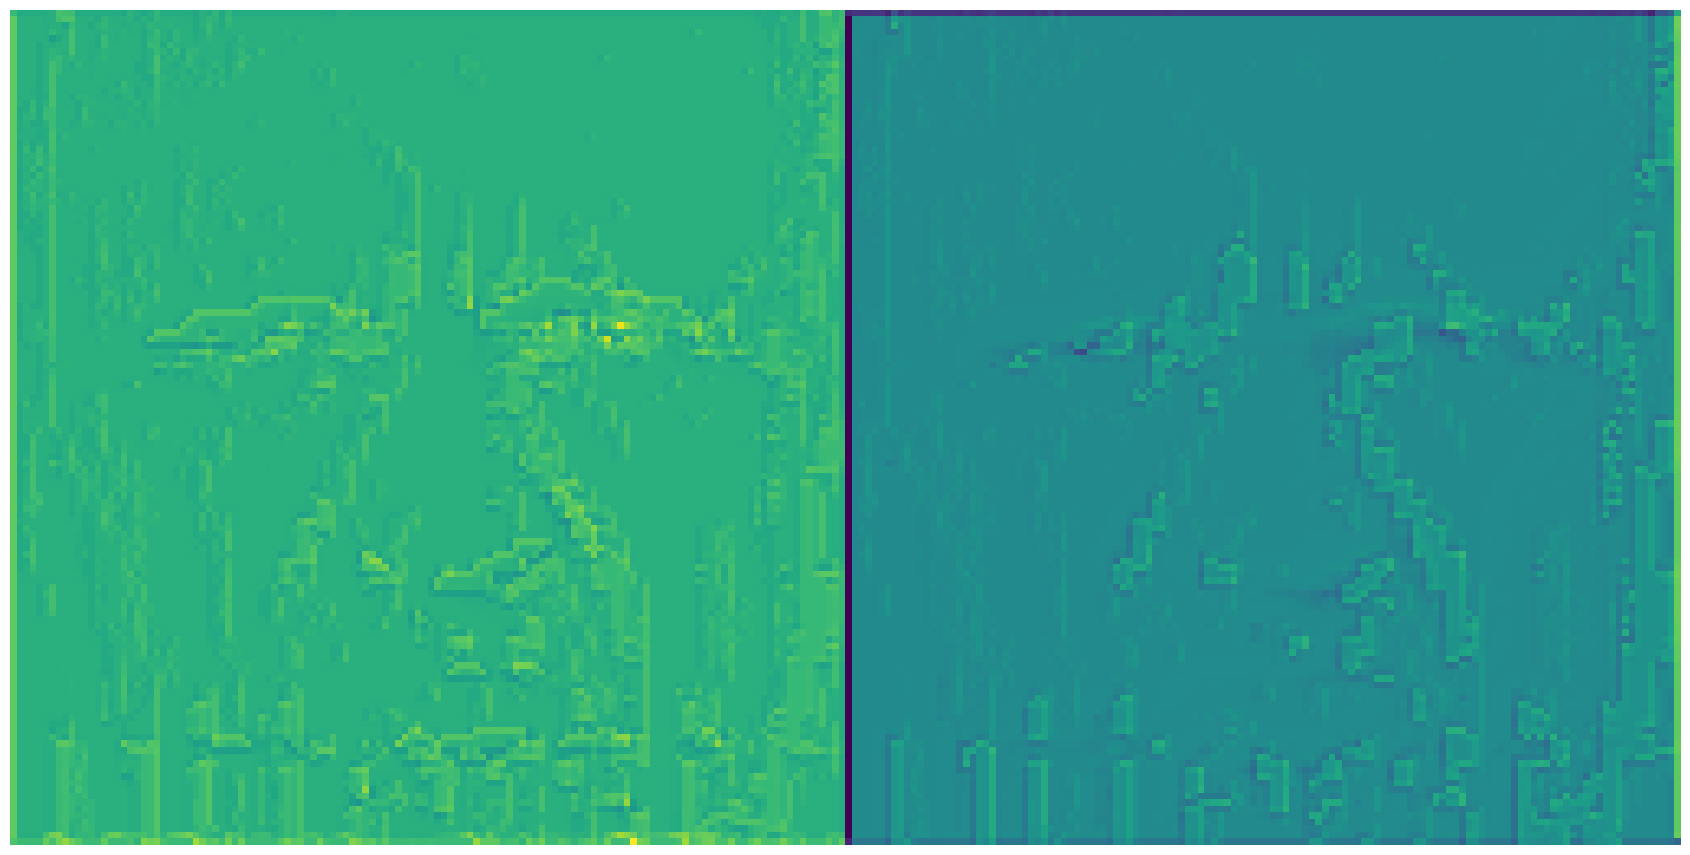

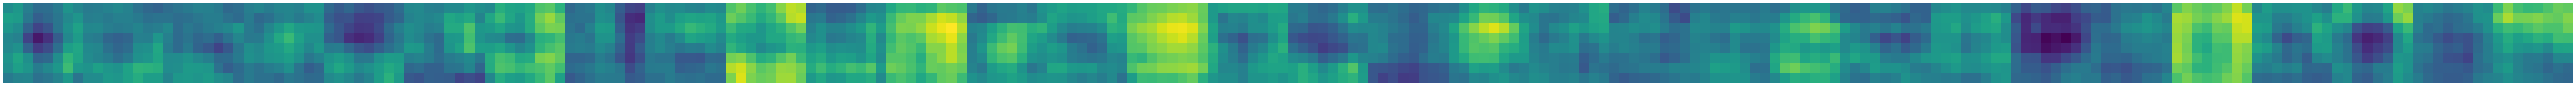

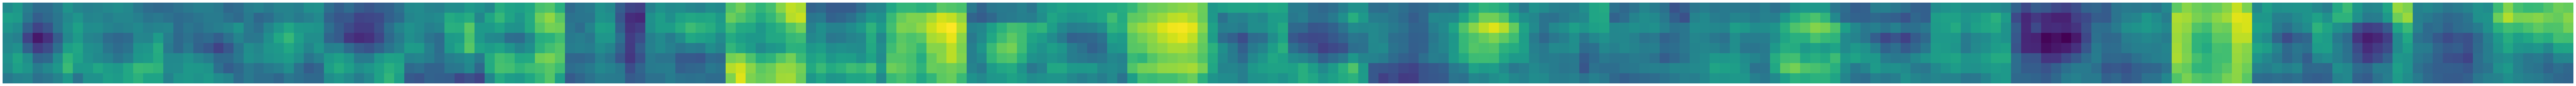

In [ ]:
for i,f_map in enumerate(f_maps):
  plt.figure(figsize = (128,128))
  curr_shape = f_map.shape
  batch,height,width,n_channels = curr_shape
  joint_maps = np.ones(shape=(height,width*n_channels))
  axs = plt.subplot(len(f_maps), 1, i+1)
  for j in range(n_channels):
    joint_maps[...,j*width:(j+1)*width] = f_map[...,j]
  plt.imshow(joint_maps[...,0:256])
  plt.axis('off')

## Lets's pipeline it (combine it into a function)

In [ ]:
# /content/emotion-detection/test/disgusted/im100.png
def test_preds(im_path,model):
  test_image = cv2.imread(im_path)
  test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))
  plt.imshow(test_image)
  im = tf.constant(test_image, dtype = tf.float32)
  im = tf.expand_dims(im, axis = 0)

  preds = model.predict(im)
  return preds

In [ ]:
def visualize_feature_maps(model,im_path):
  feature_maps = [layer.output for layer in model.layers[1:] if is_conv(layer.name)]
  feature_maps_model = Model(inputs=model.input, outputs=feature_maps)
  f_maps=test_preds(im_path,feature_maps_model)

  max_size = 0
  for f_map in f_maps:
    curr_shape = f_map.shape
    print(curr_shape)
    max_size = tf.math.maximum(curr_shape[1],max_size)

  for i,f_map in enumerate(f_maps):
    plt.figure(figsize = (max_size,max_size))
    curr_shape = f_map.shape
    batch,height,width,n_channels = curr_shape
    joint_maps = np.ones(shape=(height,width*n_channels))
    axs = plt.subplot(len(f_maps), 1, i+1)
    for j in range(n_channels):
      joint_maps[...,j*width:(j+1)*width] = f_map[...,j]
    plt.imshow(joint_maps[...,0:max_size*2])
    plt.axis('off')

1/1 [==============================] - 1s 697ms/step
(1, 128, 128, 32)
(1, 128, 128, 32)
(1, 128, 128, 32)
(1, 128, 128, 32)
(1, 128, 128, 32)
(1, 128, 128, 32)
(1, 128, 128, 16)
(1, 128, 128, 16)
(1, 8, 8, 1280)
(1, 8, 8, 1280)


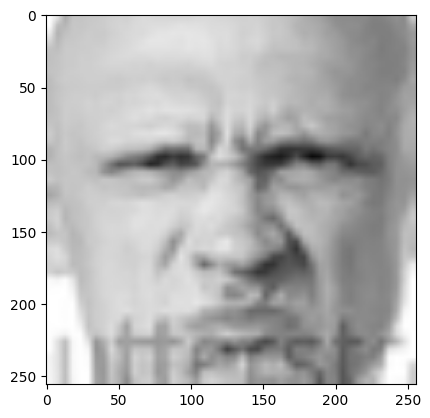

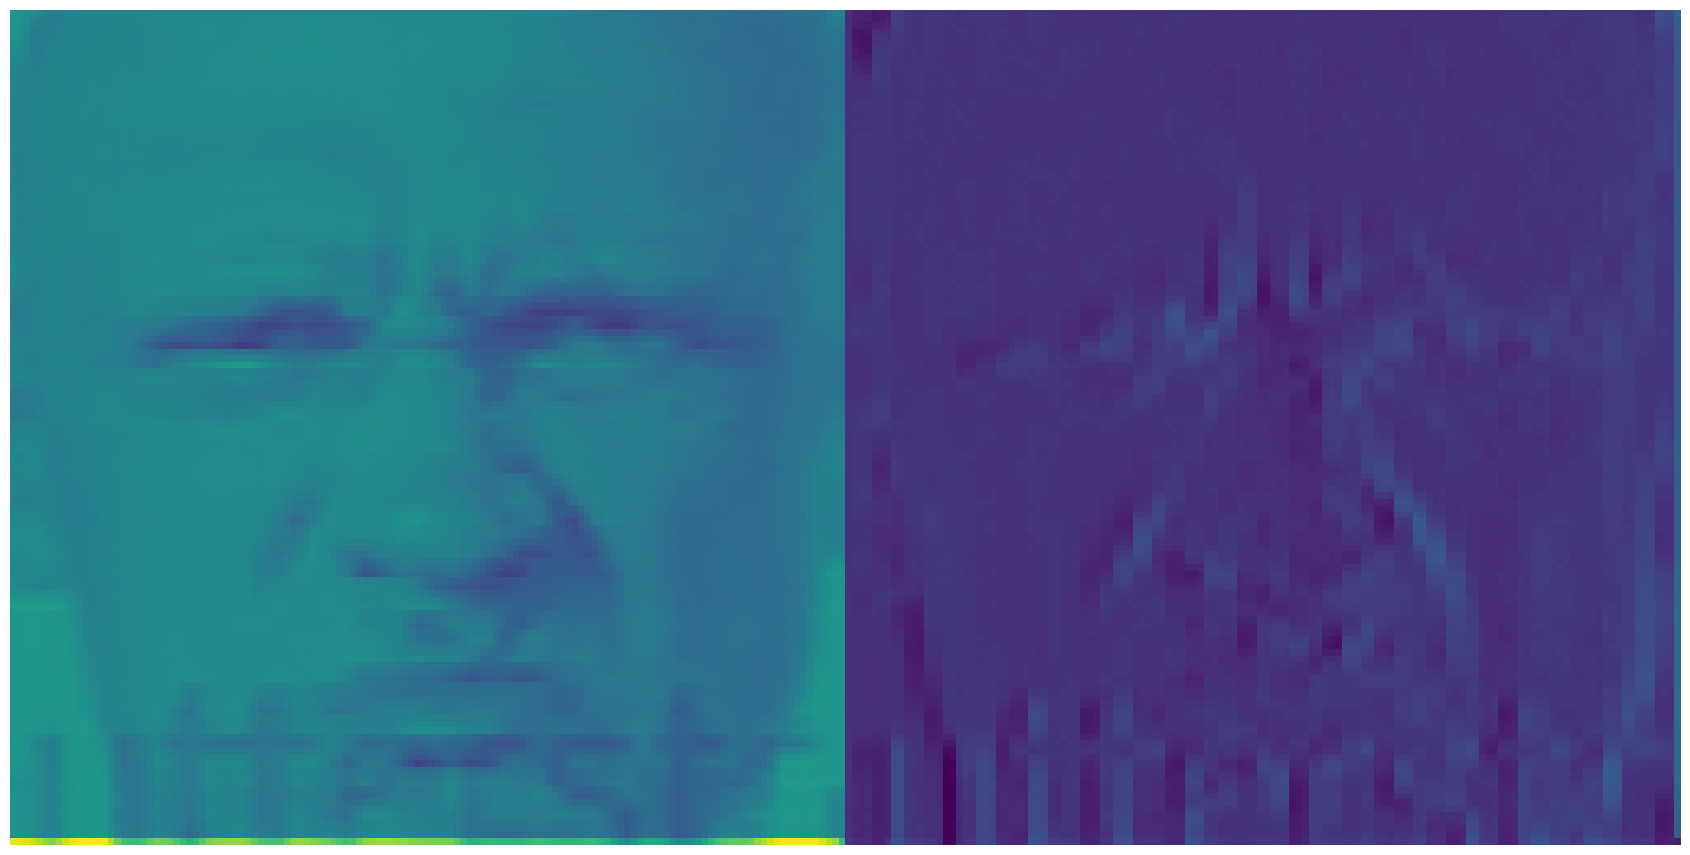

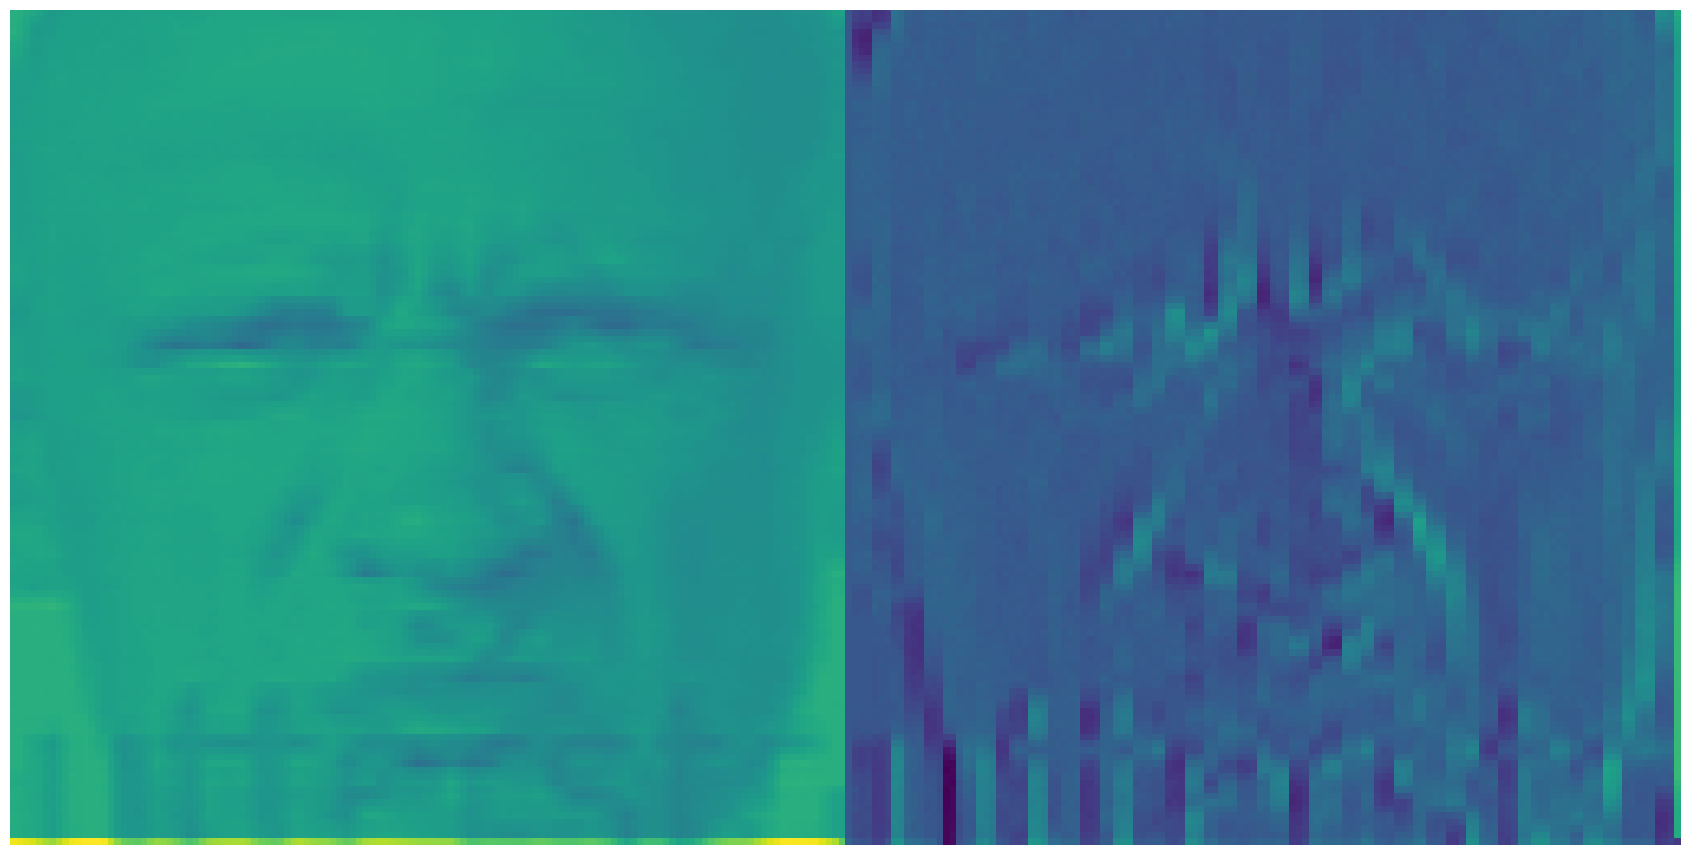

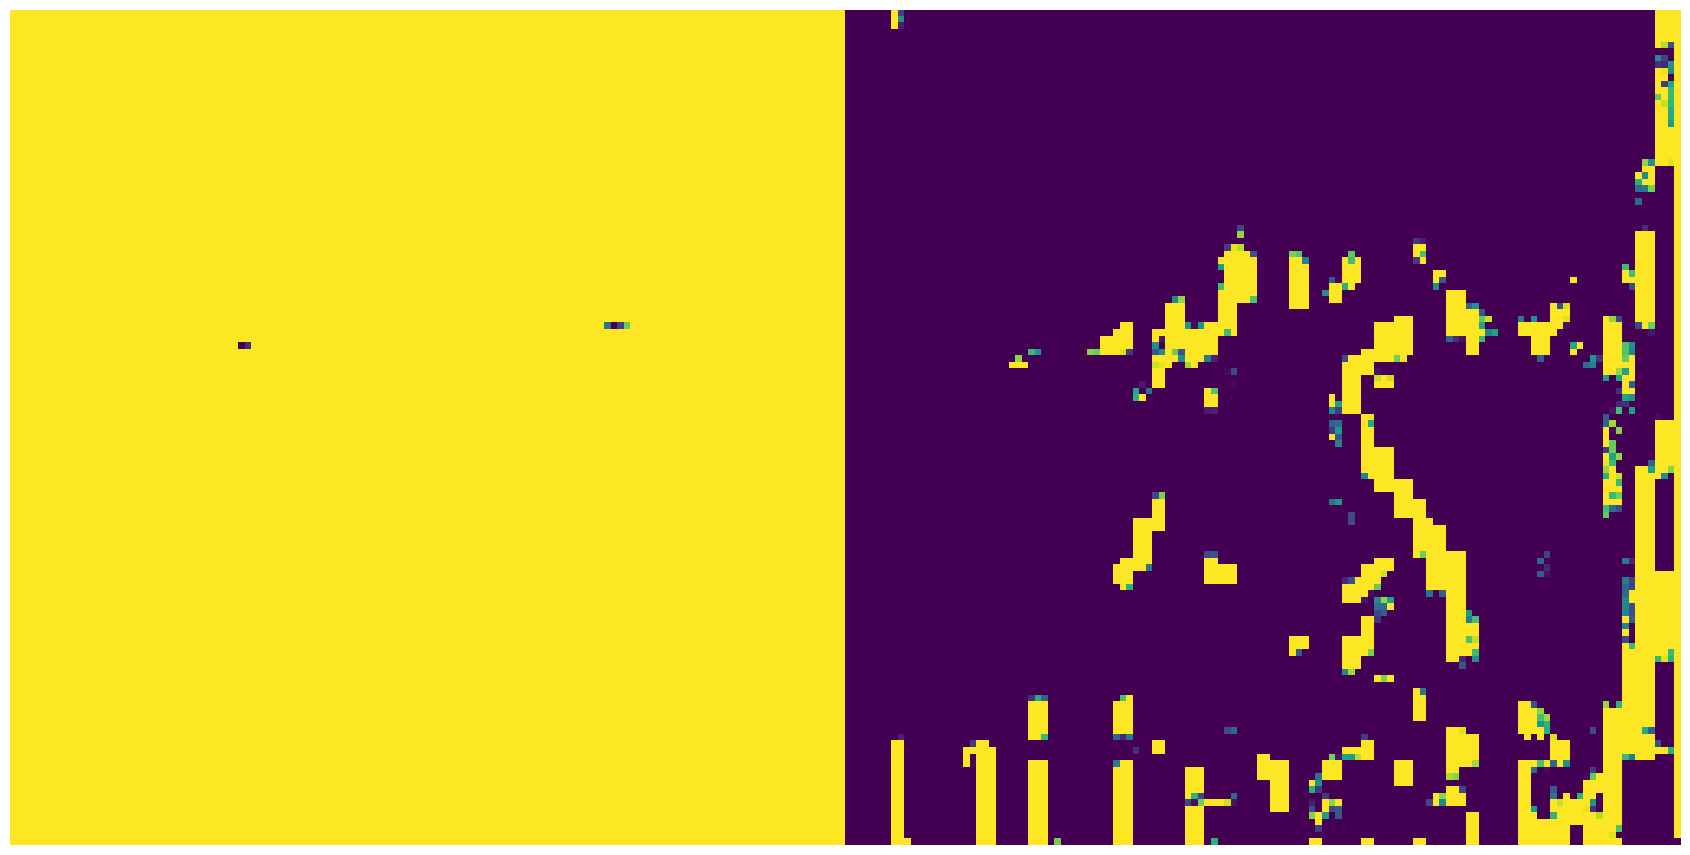

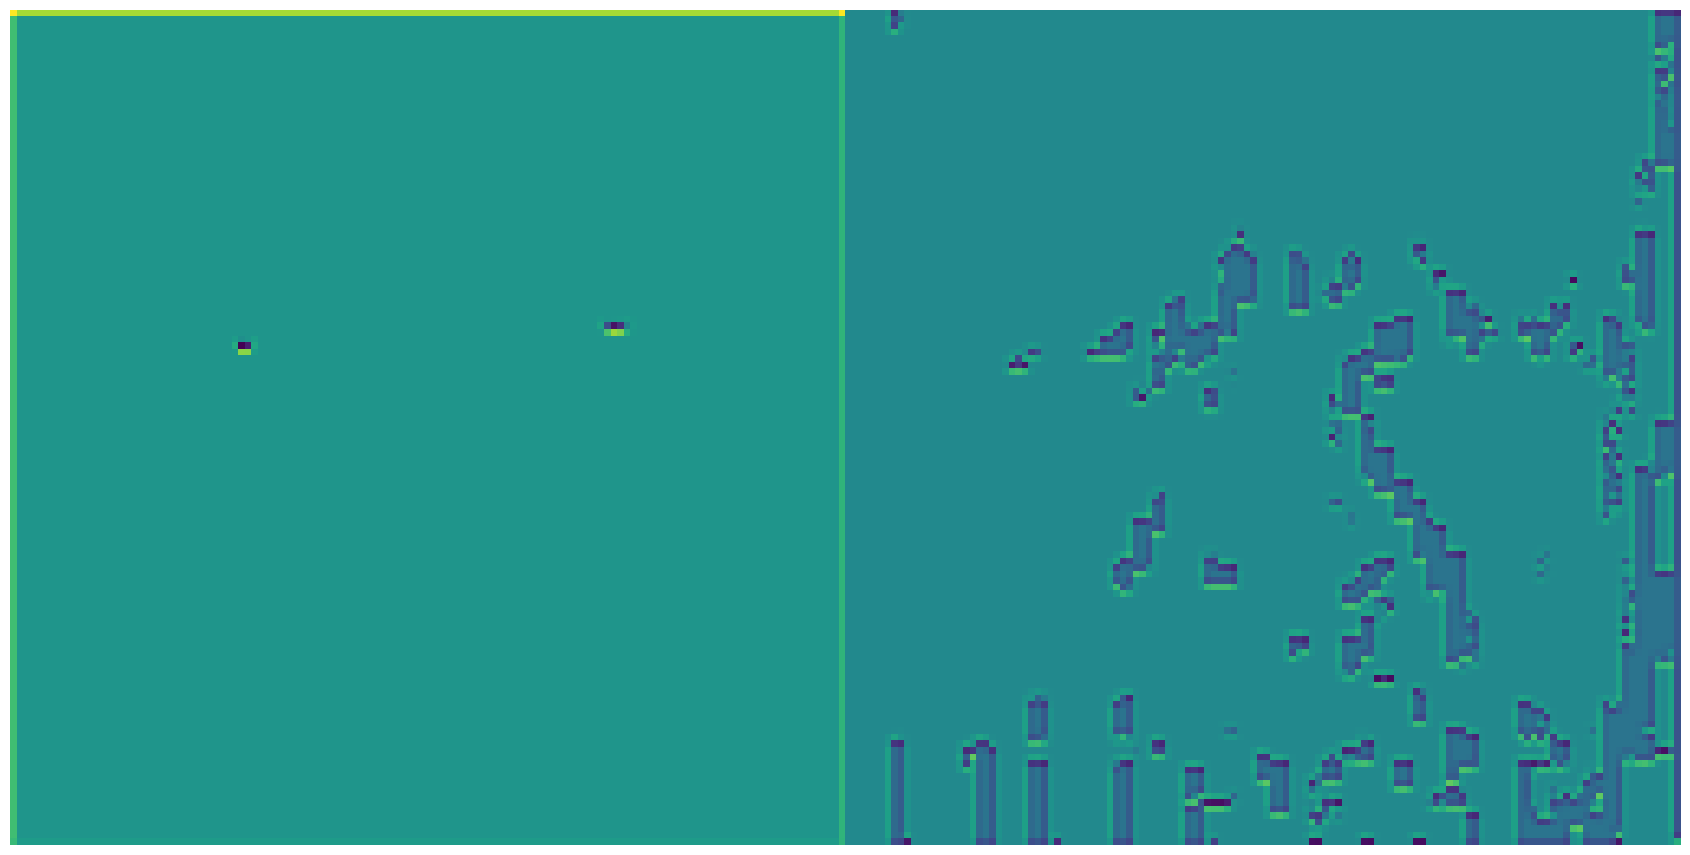

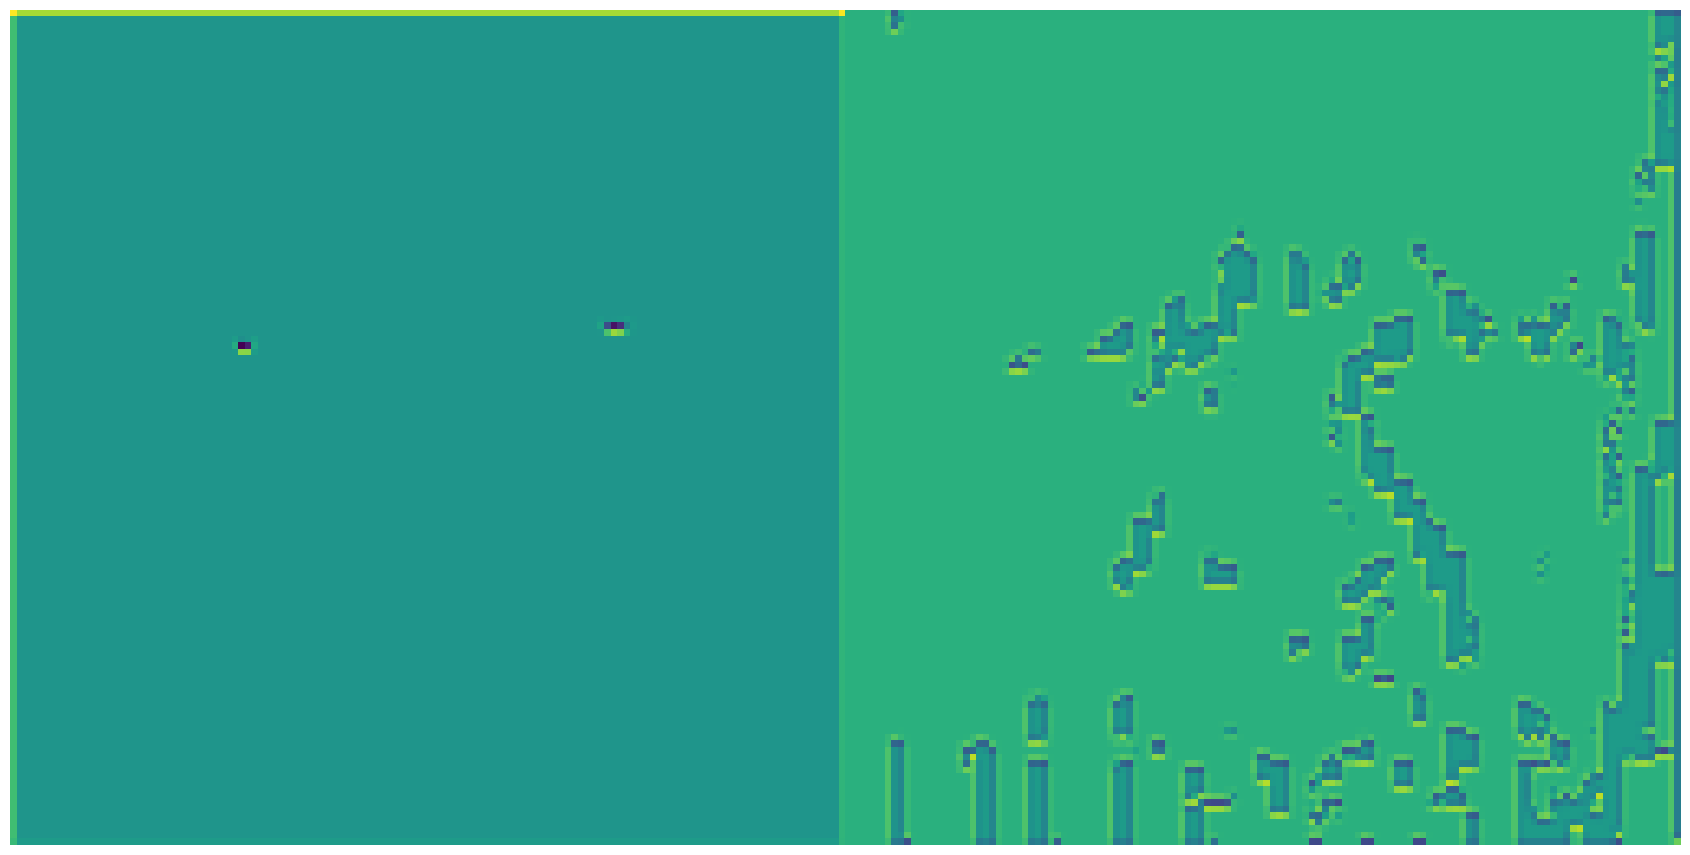

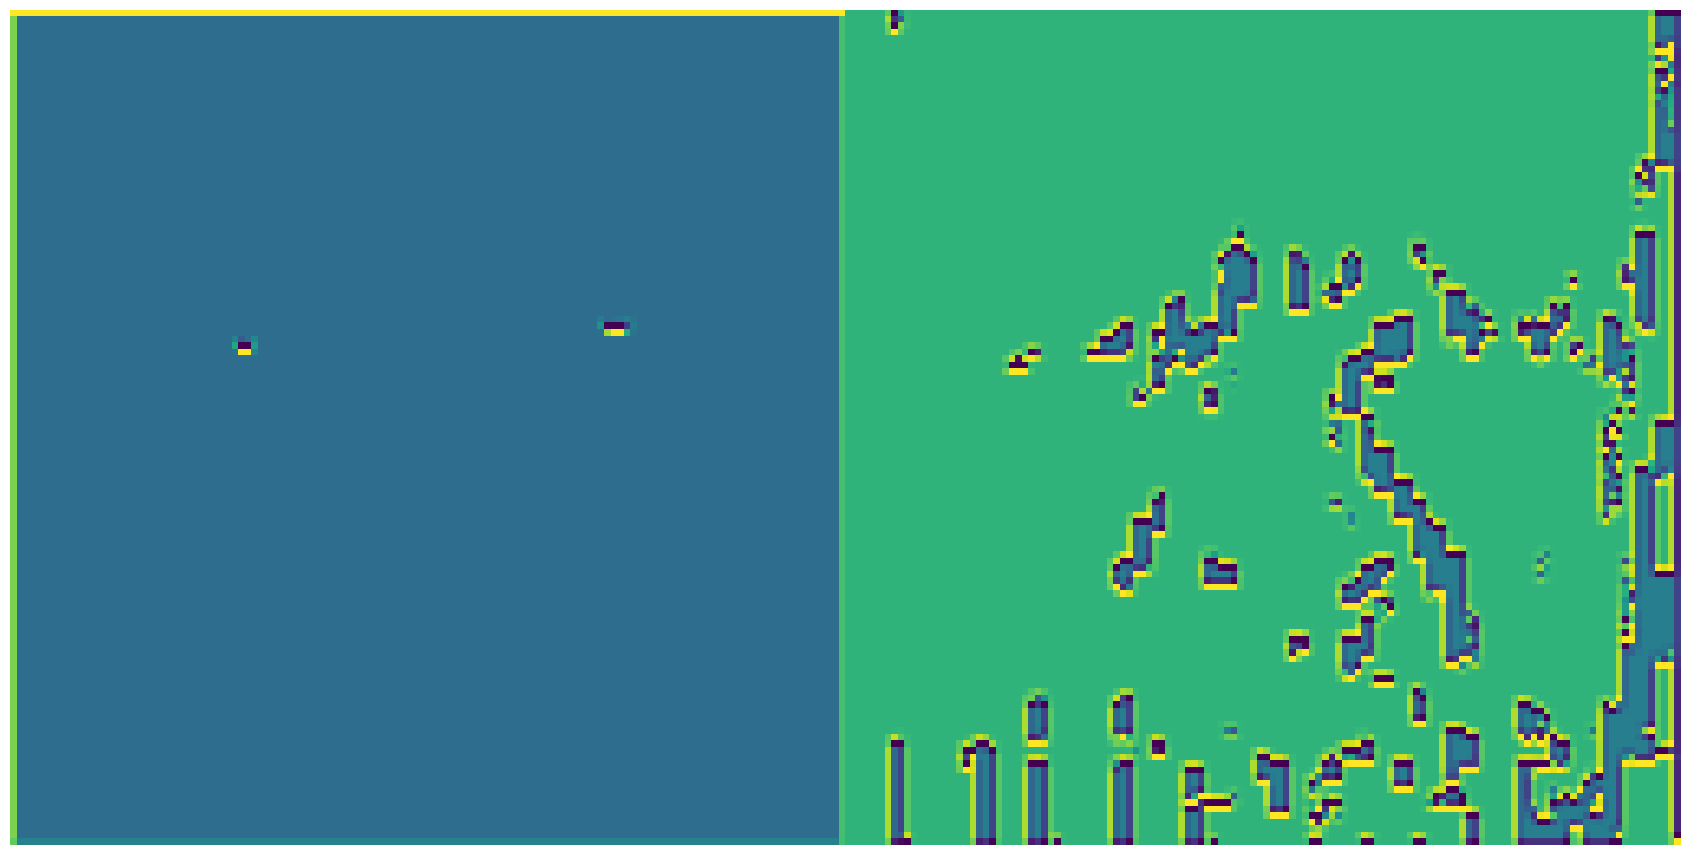

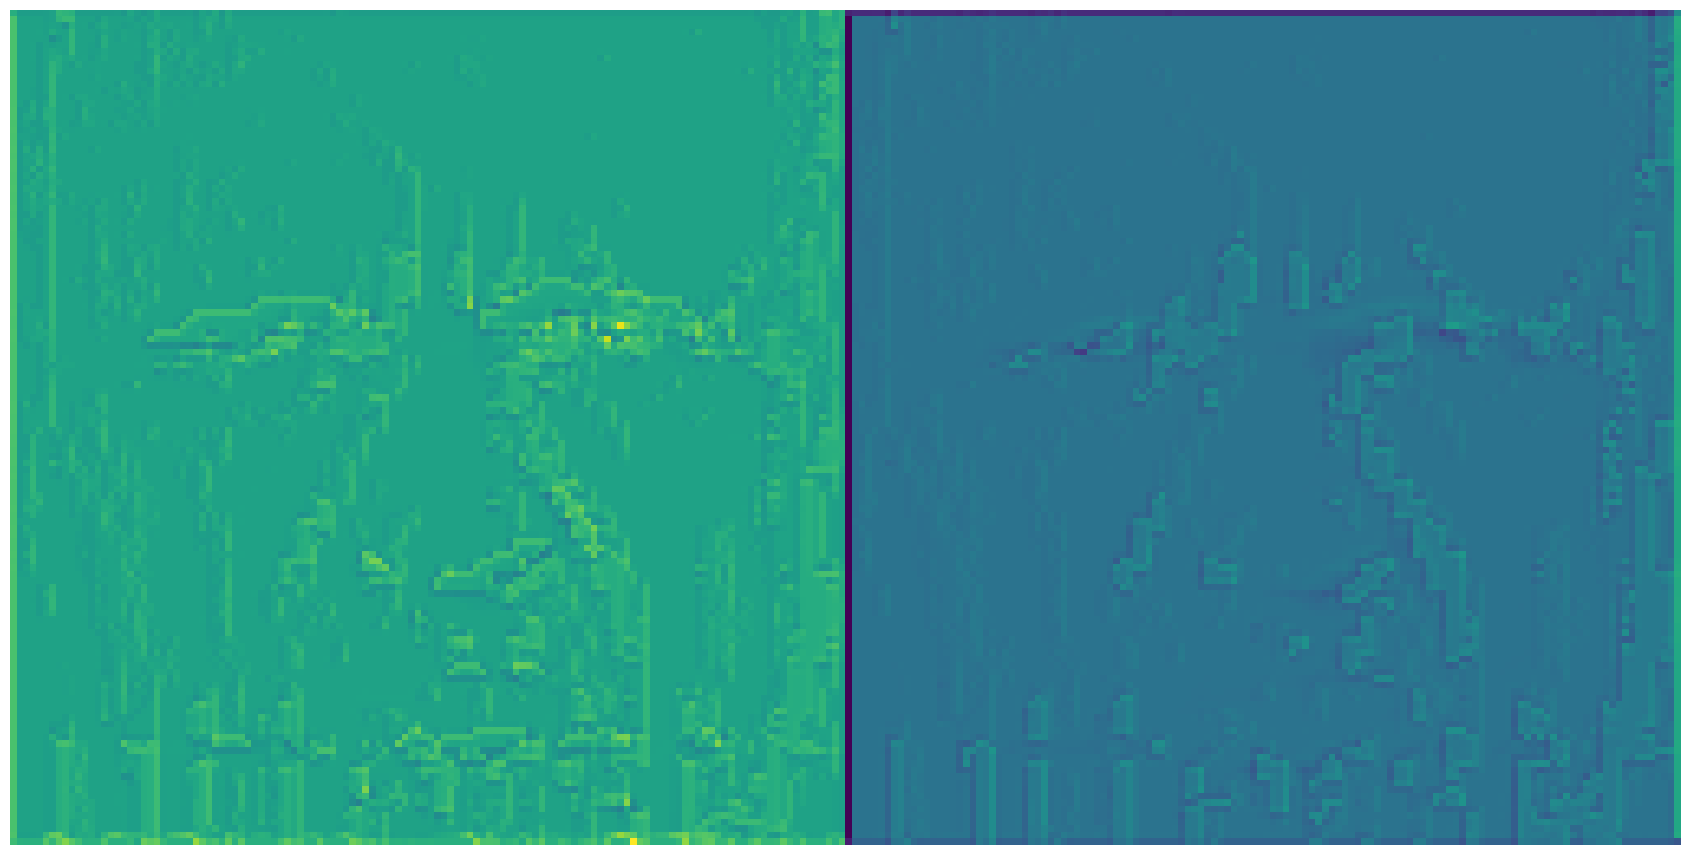

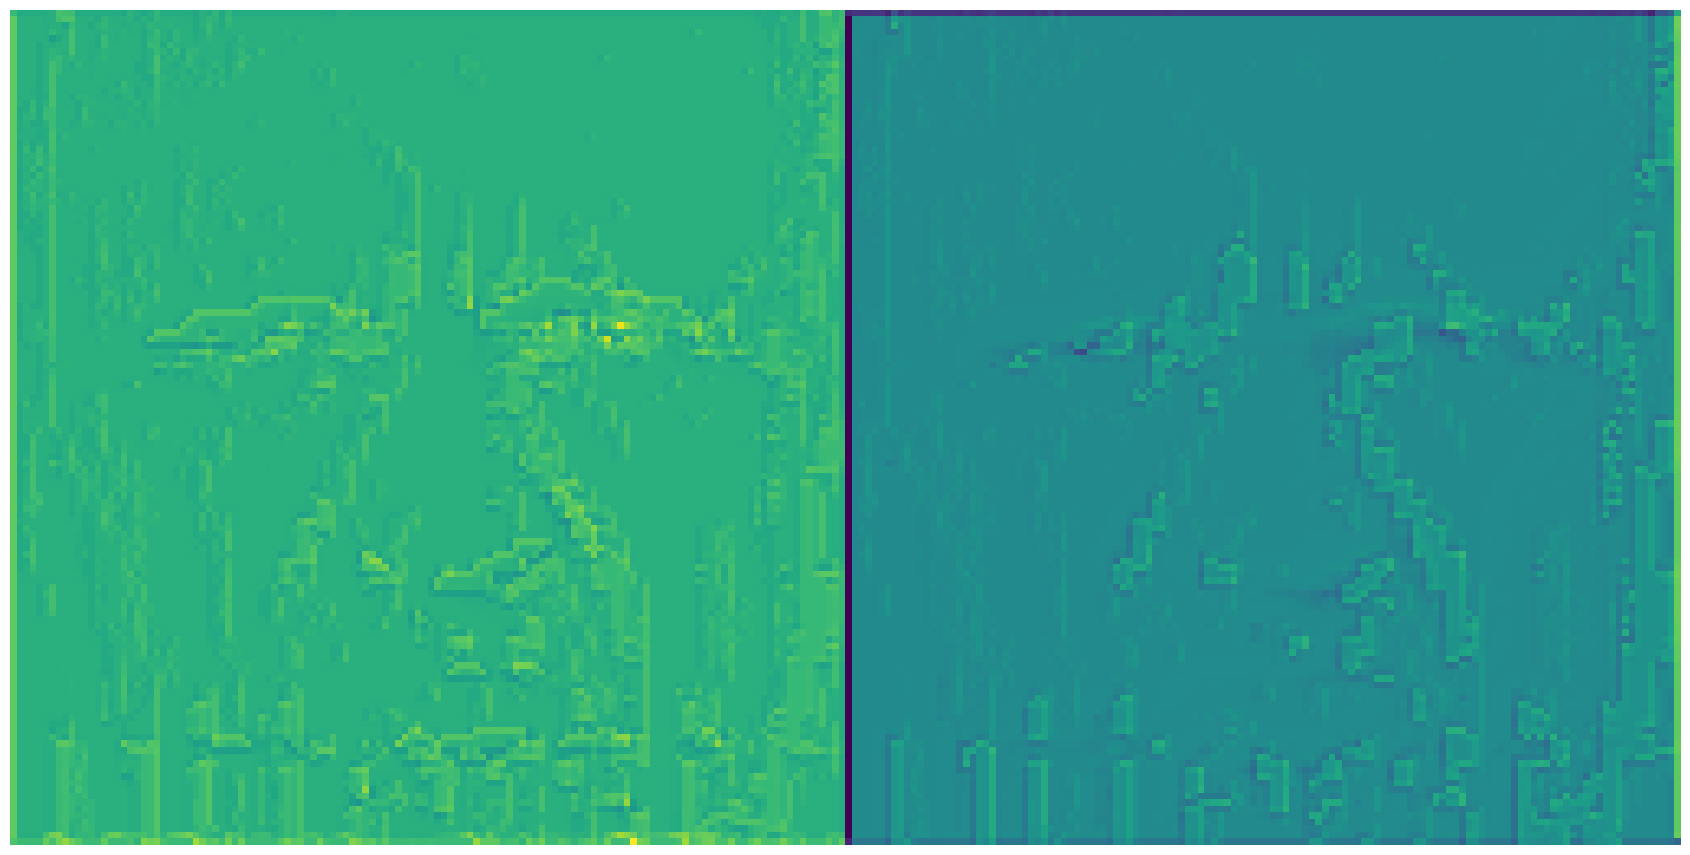

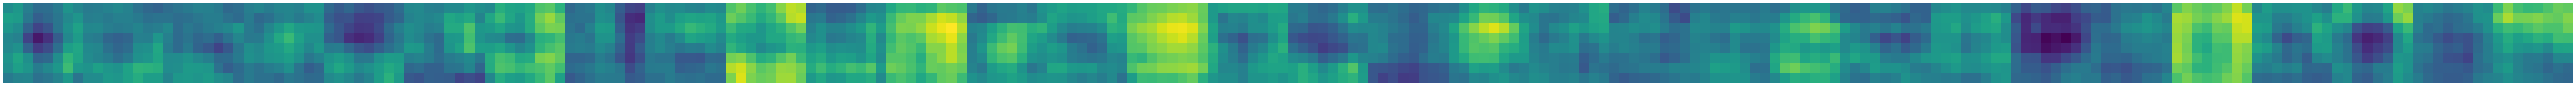

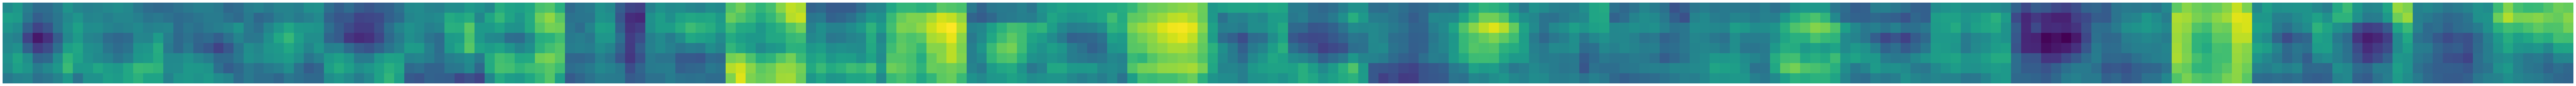

In [ ]:
visualize_feature_maps(base_model,'/content/emotion-detection/test/disgusted/im100.png')

1/1 [==============================] - 1s 748ms/step
(1, 128, 128, 32)
(1, 128, 128, 32)
(1, 128, 128, 32)
(1, 128, 128, 32)
(1, 128, 128, 32)
(1, 128, 128, 32)
(1, 128, 128, 16)
(1, 128, 128, 16)
(1, 8, 8, 1280)
(1, 8, 8, 1280)


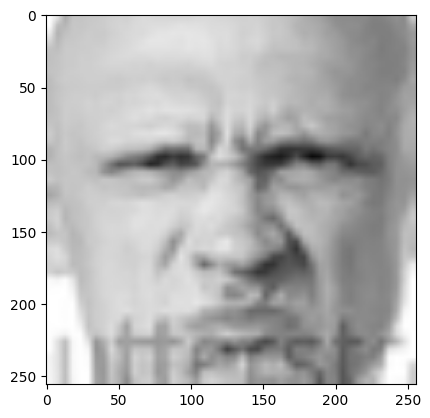

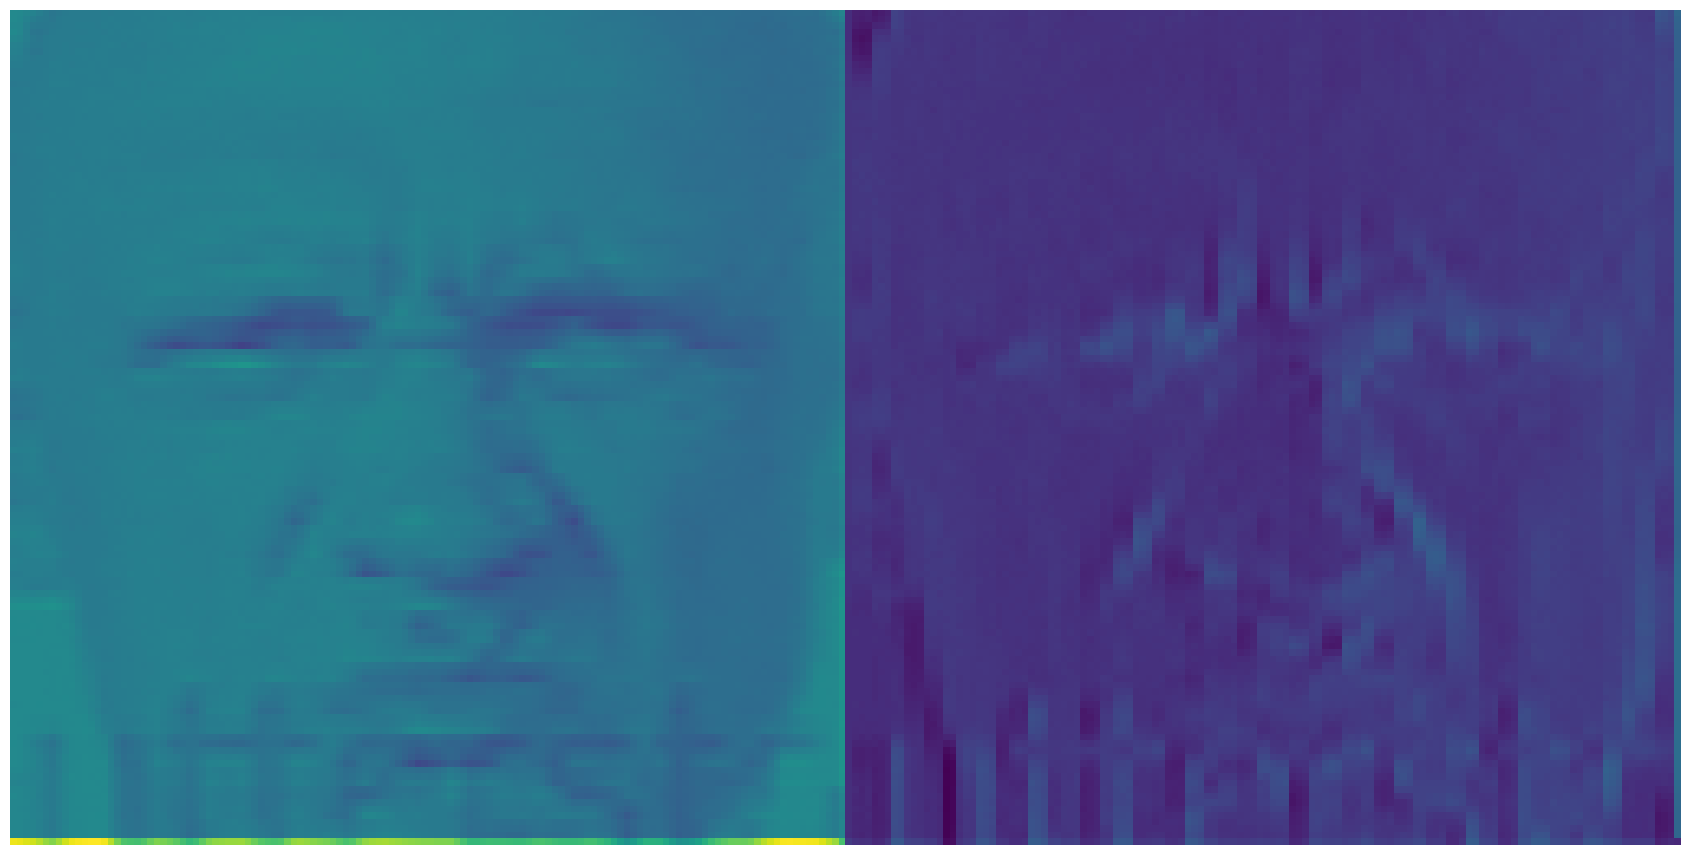

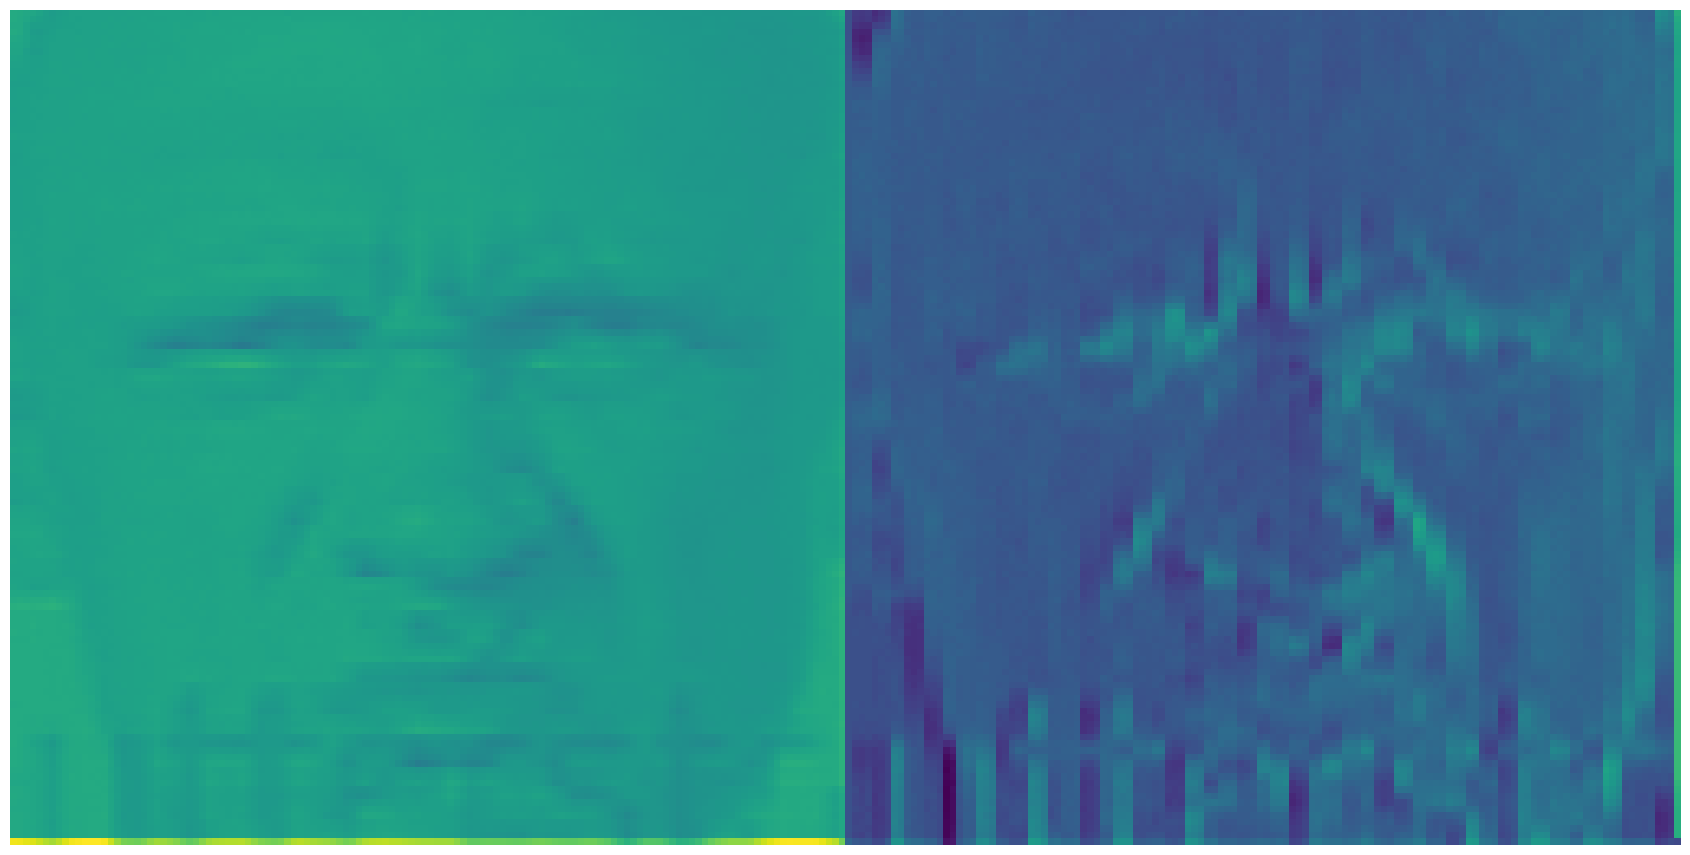

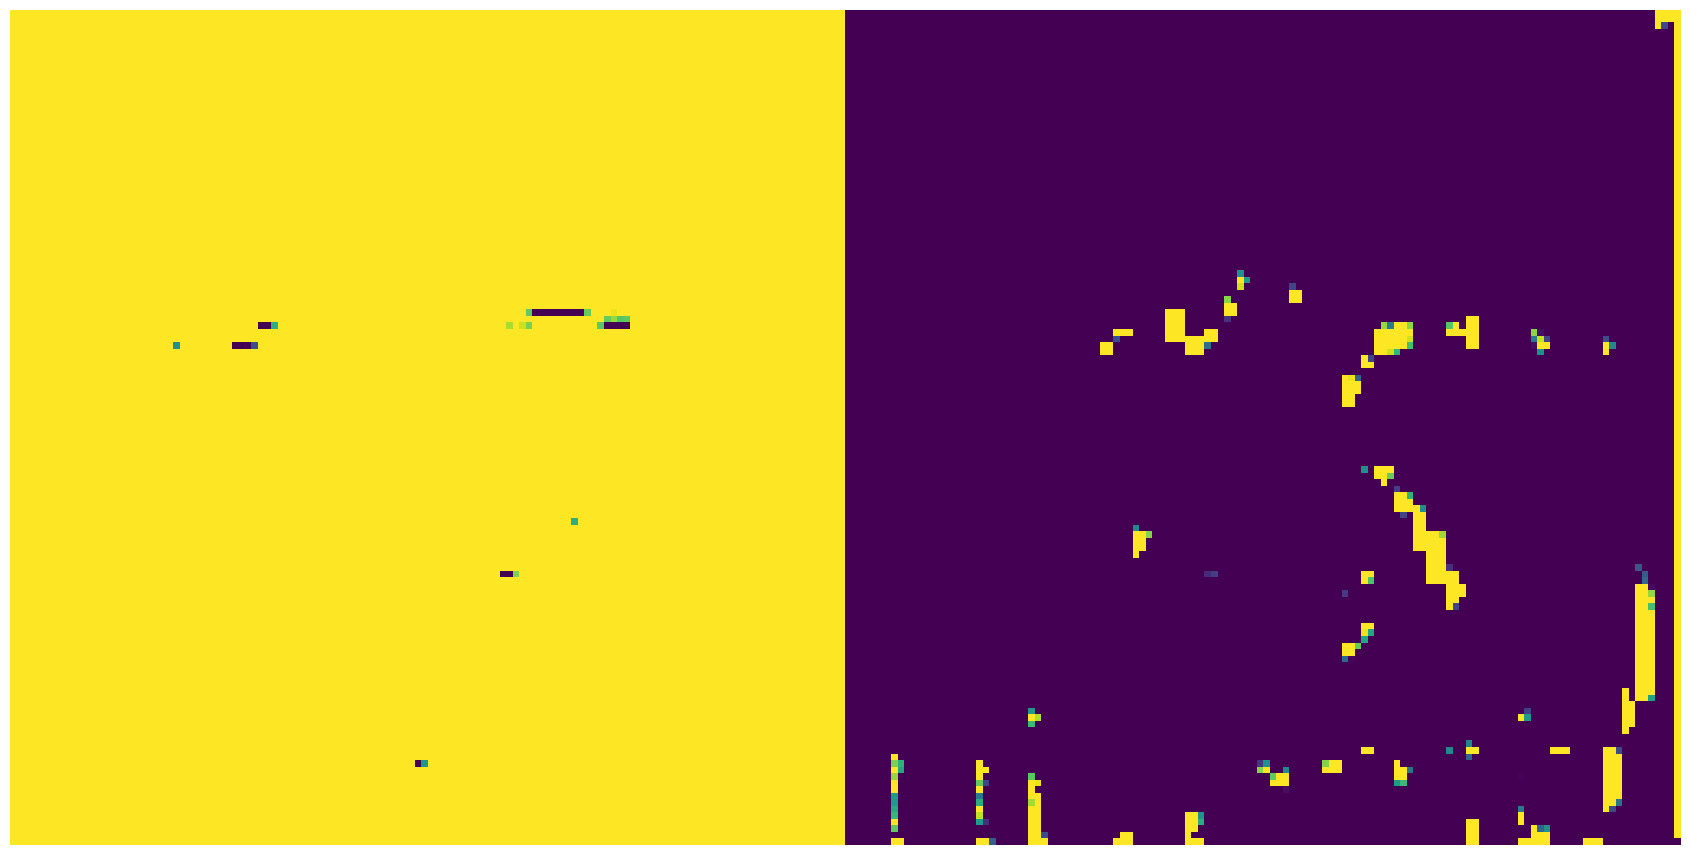

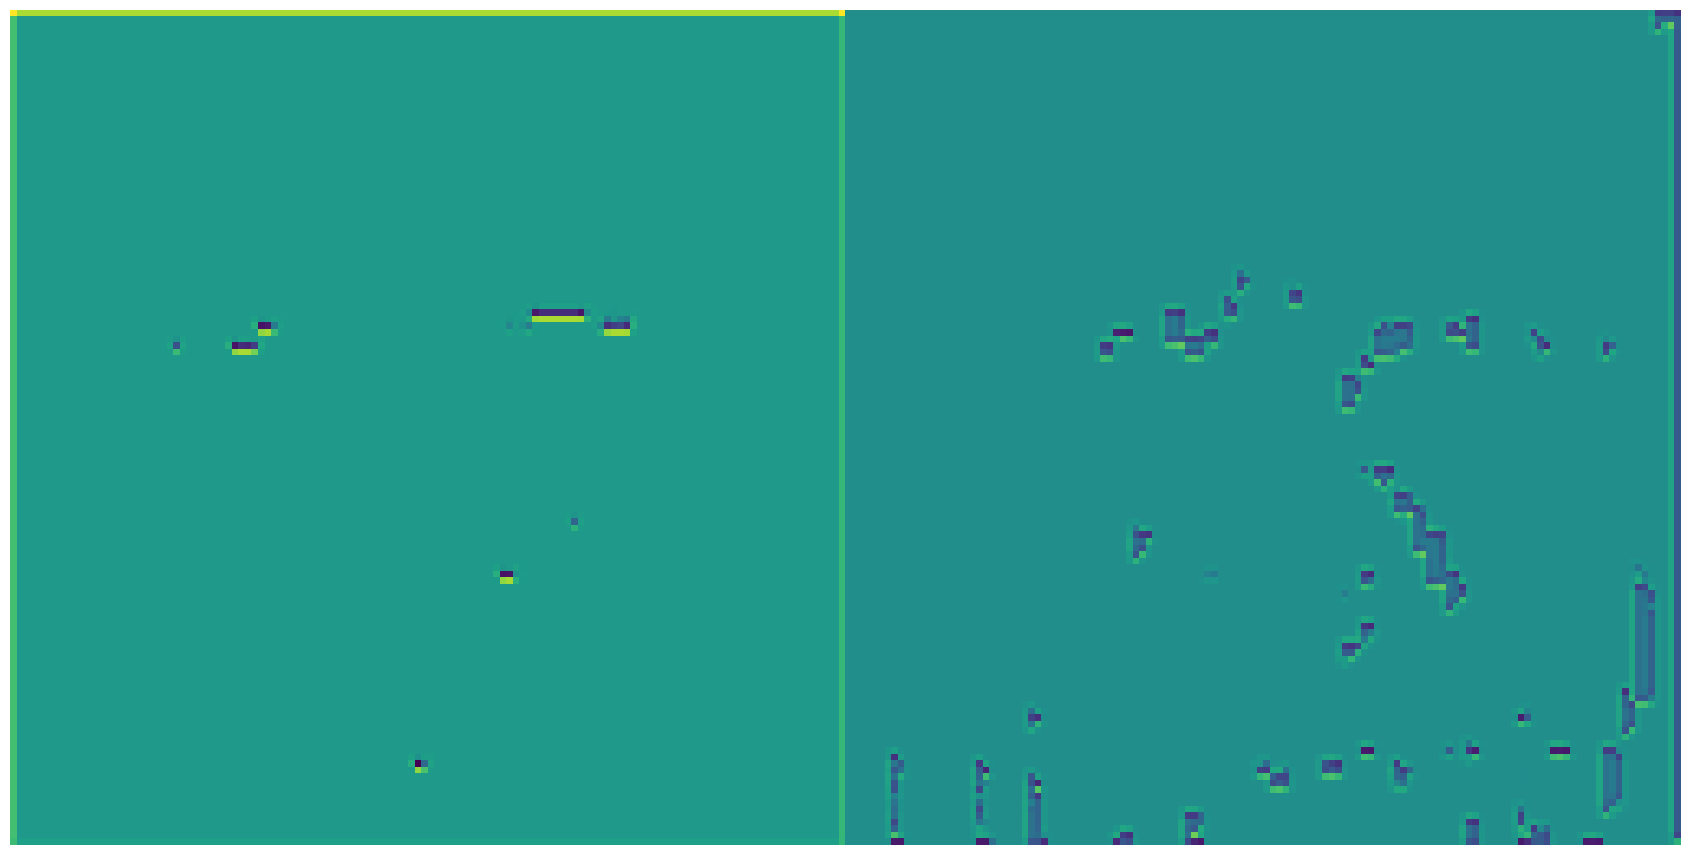

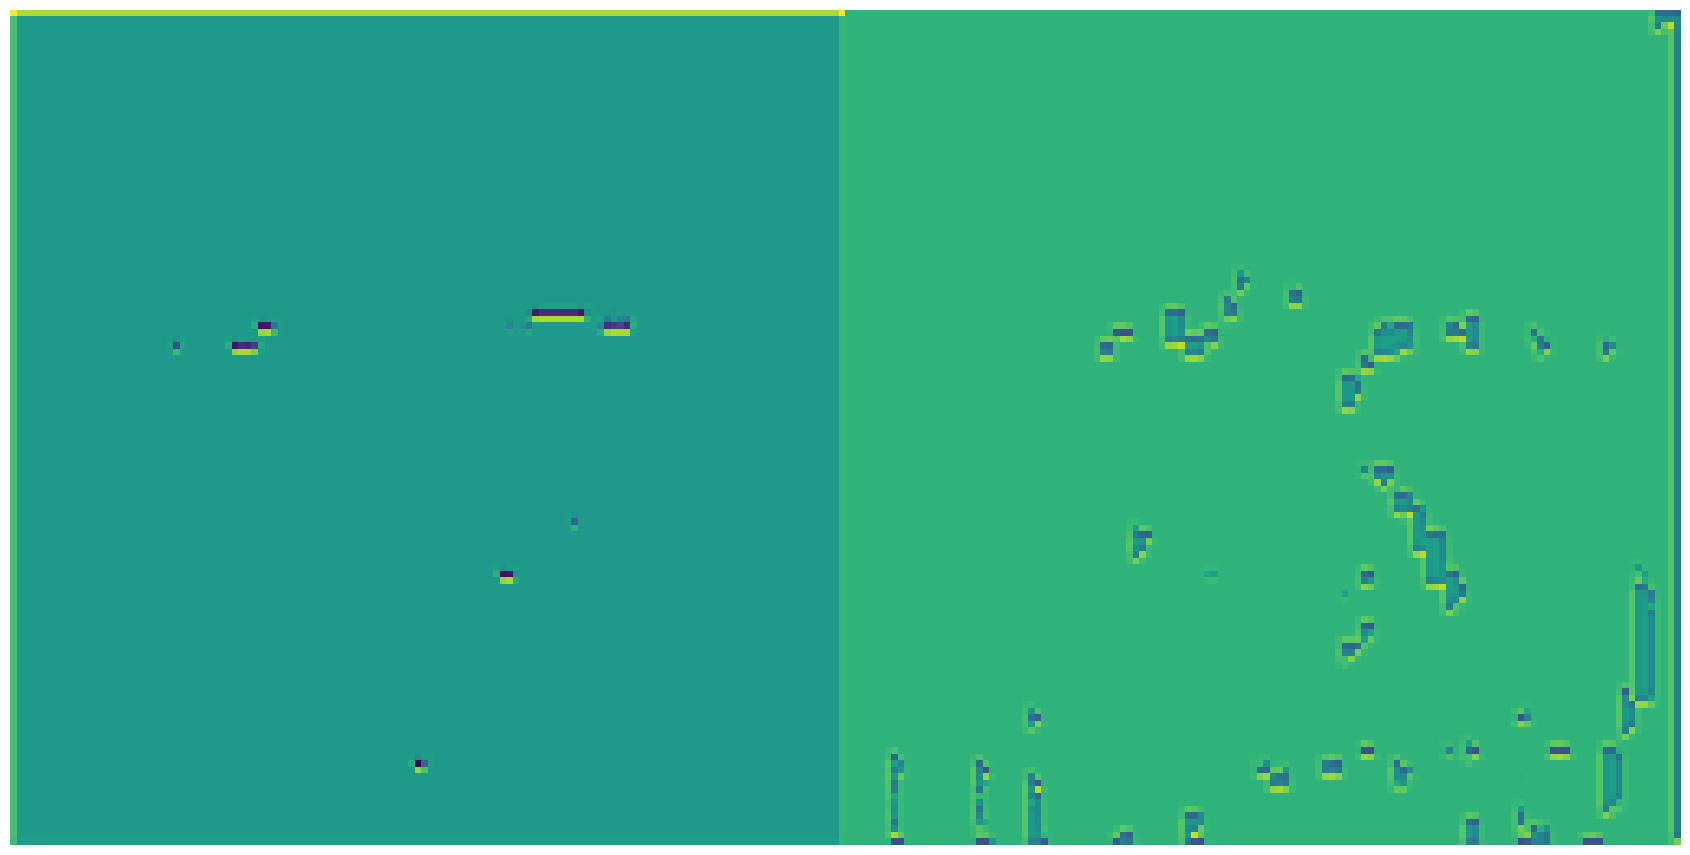

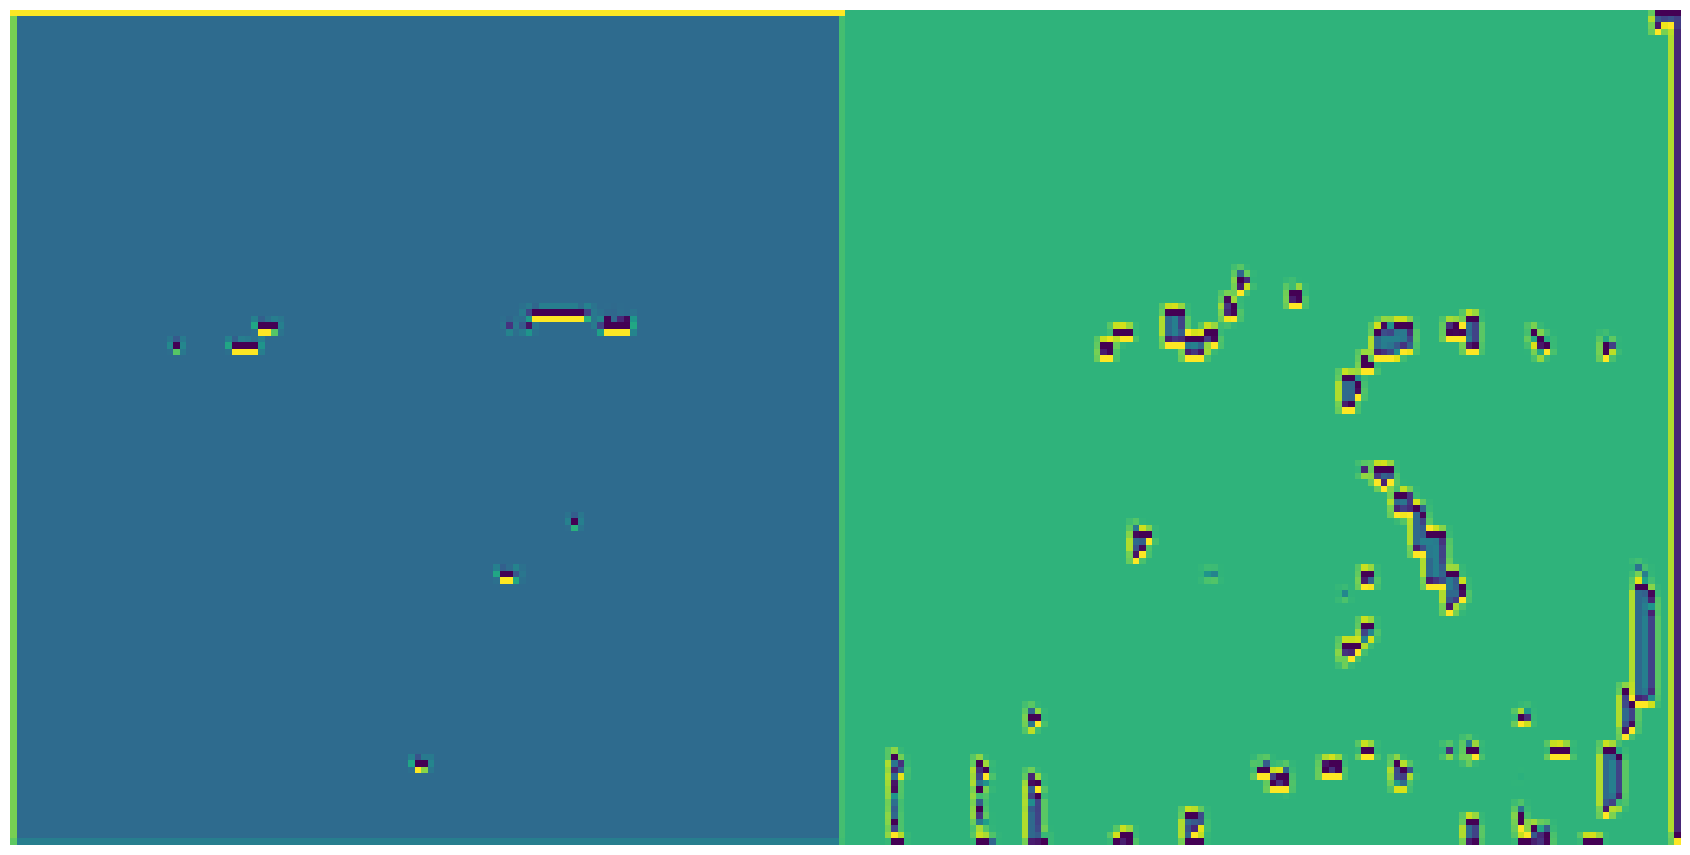

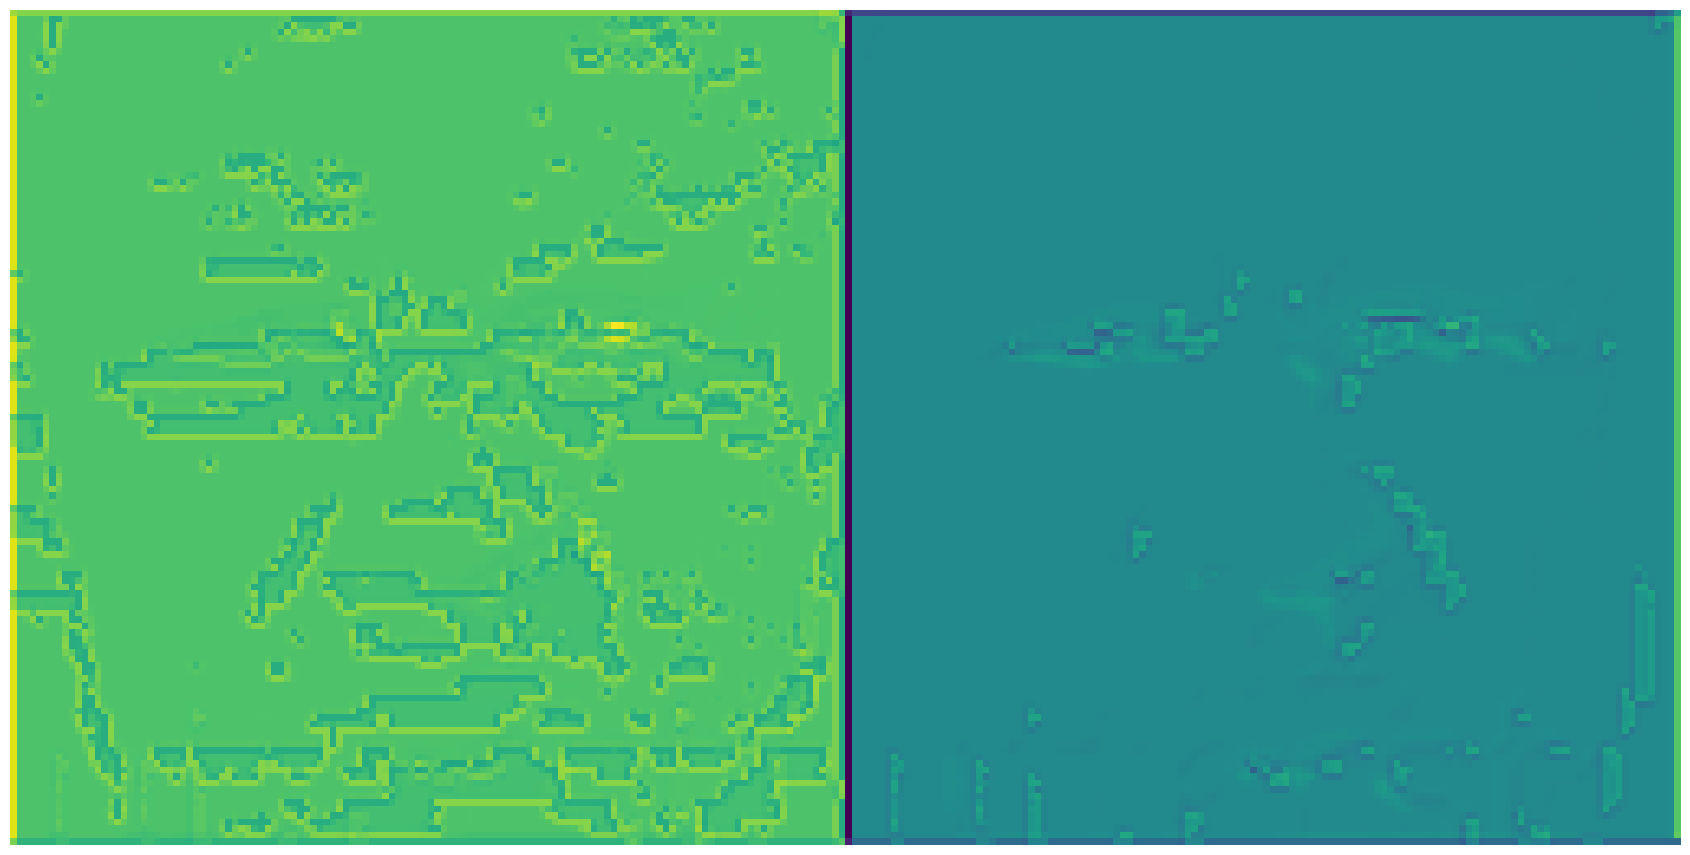

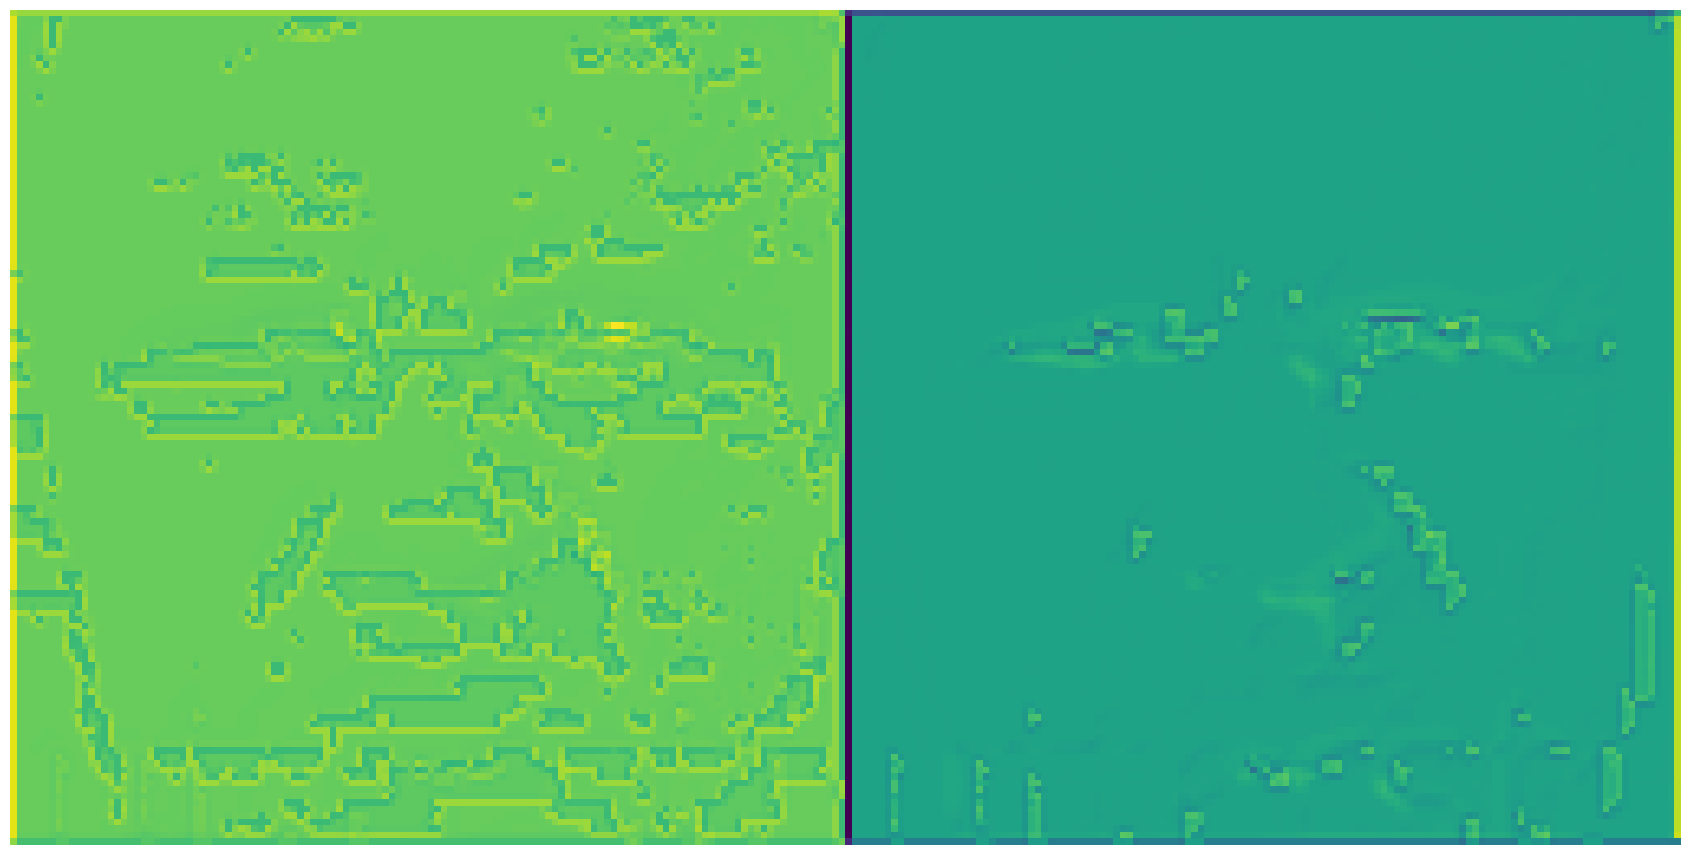

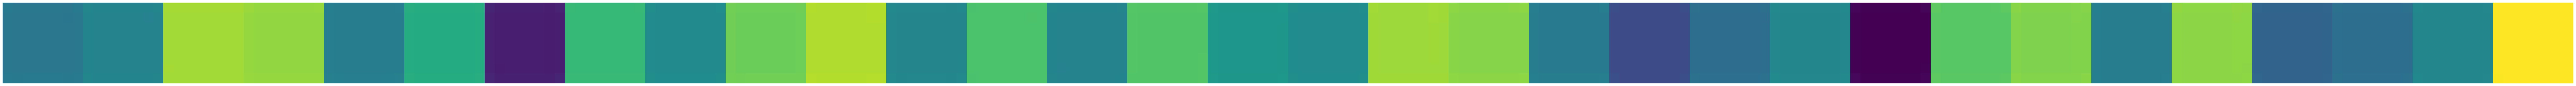

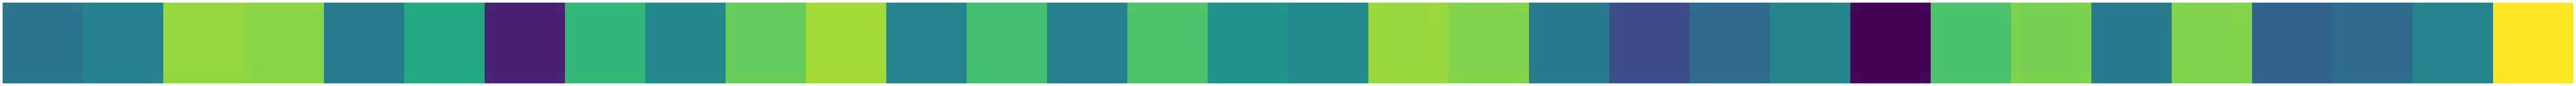

In [ ]:
visualize_feature_maps(backbone,'/content/emotion-detection/test/disgusted/im100.png')

1/1 [==============================] - 0s 214ms/step
(1, 254, 254, 64)
(1, 125, 125, 132)


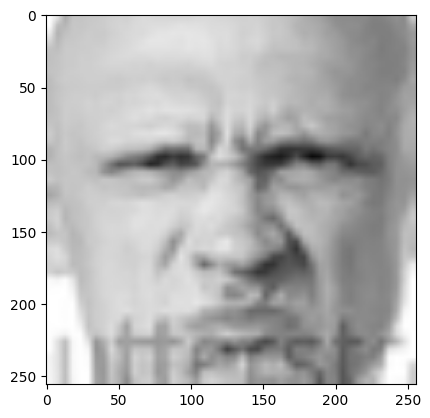

In [ ]:
visualize_feature_maps(lenet_model,'/content/emotion-detection/test/disgusted/im100.png')